## Preprocess data in successive stages
- [0. Select samples and down-sample cells](#downsample_cells)
- [1. Arcsinh normalization](#arcsinh_norm)
- [2. Set an upper ceiling value on CyTOF intensity](#upper_ceiling)
- [3. Initial clustering to remove doublets](#clustering1)
- [3. Filter doublets, RBCs, and T-cell cluster from MultiplexGroup 1 with low CD4/CD8 artifact](#filter_doublets_RBC_Tlow)
- [4. COMBAT Batch correction per cell-type](#batch_per_celltype)
- [5. Optional repleat clustering after COMBAT but before cNMF](#clustering2)
- [6. Run cNMF and regress out platelet / fixation artifact](#cNMF)
- [7. Run clustering on the COMBAT / cNMF corrected data](#clustering3)
- [8. Run subclustering on B-cells, myeloid cells, and T/NK cells](#Subclustering)
     - [8a. B cells](#Subclustering/Subcluster.Cytof.B.ipynb)
     - [8b. Myeloid cells](#Subclustering/Subcluster.Cytof.Myeloid.ipynb)
     - [8c. T/NK cells](#Subclustering/Subcluster.Cytof.TNK.ipynb)
- [9. Final clustering after filtering doublets found during subclustering](#clustering4)
- [10. Make figures](#figures)
     - [10a. Marker plot](#markerplot)
     - [10b. UMAP DPI](#umap_dpi)
     - [10c. UMAP cell type](#umap_celltype)
     - [10d. UMAP batch](#umap_batch)

Autosaving every 60 seconds


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


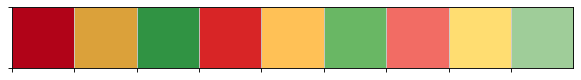

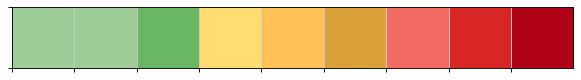

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%autosave 60

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import glob
import os
import palettable

from joblib import parallel_backend

import sys
sys.path.append('../../../Code')
from utils import save_adata, read_adata, pca_cytof
sys.path.append('../../../Code/cNMF')
from cnmf import save_df_to_npz

import matplotlib.gridspec as gridspec


sc.settings.set_figure_params(dpi=80, vector_friendly=False, ipython_format='png')
gcs = False

colors = np.array([x for x in palettable.tableau.TrafficLight_9.mpl_colors])
sns.palplot(colors)
sns.palplot(colors[[8,8,5, 7, 4, 1, 6,3,0], :])
dpimap = dict(zip(['0', '1', '2', '3', '4', '5', '6', '7', '8'], colors[[8,8,5, 7, 4, 1, 6,3,0], :]))
dpimap['0'] = palettable.tableau.TableauMedium_10.mpl_colors[-1]

In [2]:
adir = '../../../../data/InVivo/Cytof/'
project_name = 'Full_IRF_SerialSac_Cytof_Fixid.1M'
results_dir = '../../../../results'


In [3]:
! ls ../../../../data/InVivo/Cytof/

 Archive
 Broadclustering.Counts.Update20200513.tsv
'Copy of 49e_baseline_dates.xlsx'
 Full_IRF_SerialSac_Cytof_Fixid.15M.raw.h5ad
 Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative.h5ad
 Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative.npz
 Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.SubclusterBMyeloidTNK.UMAP.Final.UMAPdata.tsv
 Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.BOnlyIter1.h5ad
 Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.MyeloidIter1.h5ad
 Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.MyeloidIter2.h5ad
 Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.MyeloidIter2DCsBasophils.h5ad
 Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterB.h5ad
 Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloid.h5ad
 Full_IRF_SerialSac_

## Load in the unprocessed data from all of the samples together

In [43]:
baseline_raw_file = '../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.15M.raw.h5ad'

In [44]:
adata = read_adata(baseline_raw_file, ext='.h5ad', gcs=False)

Only considering the two last: ['.raw', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].


In [47]:
Z = adata.obs[['animal', 'DPI', 'Multiplex_Group', 'sample']]

In [53]:
cellcounts = Z.groupby(['animal', 'DPI', 'Multiplex_Group']).count().dropna().rename(columns={'sample':'num_cells'}).reset_index()

In [64]:
clinical = pd.read_csv('../../../../data/InVivo/clinical_scores_fixid.tsv', sep='\t', header=[0,1])
sgmap = dict(zip(clinical.iloc[:, 2], clinical.iloc[:, 0]))
cmap = dict(zip(clinical.iloc[:, 2], clinical.iloc[:, 1]))

cellcounts['cohort'] = cellcounts['animal'].replace(sgmap)
cellcounts['challenge_Group'] = cellcounts['animal'].replace(cmap)

cellcounts

animal  DPI Multiplex_Group  num_cells                            cohort  \
0   NHP07  -14  Barcode tube 2    67381.0  Terminal (routine manipulations)   
1   NHP07   -4  Barcode tube 2   100772.0  Terminal (routine manipulations)   
2   NHP07    3  Barcode tube 2   147977.0  Terminal (routine manipulations)   
3   NHP07    5  Barcode tube 2   120997.0  Terminal (routine manipulations)   
4   NHP07    7  Barcode tube 2    76905.0  Terminal (routine manipulations)   
..    ...  ...             ...        ...                               ...   
91  NHPC1   -7  Barcode tube 3    14539.0                             NHPC1   
92  NHPC2  -14  Barcode tube 6    83561.0                             NHPC2   
93  NHPC2   -2  Barcode tube 6   157998.0                             NHPC2   
94  NHPC3  -14  Barcode tube 2    56507.0                             NHPC3   
95  NHPC3   -2  Barcode tube 5    35493.0                             NHPC3   

   challenge_Group  
0                2  
1                2  
2                2  
3                2  
4                2  
..             ...  
91           NHPC1  
92           NHPC2  
93           NHPC2  
94           NHPC3  
95           NHPC3  

[96 rows x 6 columns]

In [65]:
outfn = os.path.join(results_dir, 'CyTOF_Sample_Summary.tsv')
cellcounts.to_csv(outfn, sep='\t', index=False)

<a id="downsample_cells"></a>
## Select samples and down-sample cells

In [ ]:
X = adata.obs[['animal','sample', 'Multiplex_Group', 'DPI', 'DPIc', 'Period']].drop_duplicates()
X = X.sort_values(by=['sample', 'Multiplex_Group'])

In [ ]:
(fig,ax) = plt.subplots(1,1, figsize=(4,4), dpi=200)
sns.heatmap(pd.crosstab(X['animal'], X['DPI']), yticklabels=True, ax=ax)

In [ ]:
pd.crosstab(X['Multiplex_Group'], X['DPIc'])

In [ ]:
pd.crosstab(X['Multiplex_Group'], X['DPI'])

In [ ]:
ind = (X['DPI']<=0) & ~X['animal'].isin(['RA1819', 'RA1856'])
earliest_dpi = X.loc[ind, :].groupby('animal')['DPI'].max().reset_index()
earliest_dpi = pd.merge(left=earliest_dpi, right=X[['animal', 'DPI', 'DPIc', 'Multiplex_Group', 'sample', 'Period']], on=['animal', 'DPI']).sort_values(by='Multiplex_Group')
earliest_dpi

In [ ]:
ind = (X['DPI']<=0) & ~X['animal'].isin(['RA1819', 'RA1856']) & ~X['sample'].isin(earliest_dpi['sample'])
second_dpi = X.loc[ind, :].groupby('animal')['DPI'].max().reset_index()
second_dpi = pd.merge(left=second_dpi, right=X[['animal', 'DPI', 'DPIc', 'Multiplex_Group', 'sample', 'Period']], on=['animal', 'DPI']).sort_values(by='Multiplex_Group')
second_dpi

In [ ]:
samp_selection = pd.concat([earliest_dpi, second_dpi, X.loc[X['DPI']>0,second_dpi.columns]])

In [ ]:
samp_selection['Multiplex_Group'].value_counts()

In [ ]:
daygroup = pd.crosstab(samp_selection['Multiplex_Group'], samp_selection['Period'])
daygroup

In [ ]:
daygroup.sum(axis=0)

In [ ]:
daygroup.sum(axis=1)

In [ ]:
adata = adata[adata.obs['sample'].isin(samp_selection['sample']), :]

In [ ]:
## Down-sample the cells uniformly within each group

In [ ]:
vc =adata.obs['sample'].value_counts()
vc.name = 'count'
samp_selection_count = pd.merge(left=samp_selection, right=vc, left_on='sample', right_index=True, how='left')
samp_selection_count['tosample'] = np.nan
samp_selection_count.index = np.arange(samp_selection_count.shape[0])

In [ ]:
num_baseline = 300000
num_nonbaseline = 100000
for i in range(9):
    if i == 0:
        total = num_baseline
    else:
        total = num_nonbaseline
    
    subdat = samp_selection_count.loc[samp_selection_count['DPIc']==str(i),:]
    average = total / subdat.shape[0]
    ind = subdat['count']<average
    subdat.loc[ind,'tosample'] = subdat.loc[ind,'count']
    while ind.sum() > 0:
        average = (total - subdat.loc[ind, 'count'].sum()) / (~ind).sum()
        ind = (subdat['count']<average) & subdat['tosample'].isnull()
        subdat.loc[ind,'tosample'] = subdat.loc[ind,'count']
              
    subdat.loc[subdat['tosample'].isnull(), 'tosample'] = np.ceil(average)
    
    remainder = int(subdat['tosample'].sum()-total)
    subdat.iloc[:remainder, -1]-=1 
    samp_selection_count.loc[subdat.index, 'tosample'] = subdat['tosample']
samp_selection_count['tosample'] = samp_selection_count['tosample'].astype(int)

In [ ]:
samp_selection_count.groupby('DPIc')['tosample'].sum()

In [ ]:
(samp_selection_count['tosample']>samp_selection_count['count']).sum()

In [ ]:
samp_selection_count.index = samp_selection_count['sample']

In [ ]:
np.random.seed(14)

In [ ]:
sample = []
for (k,g) in adata.obs.groupby('sample'):
    if g.shape[0] == samp_selection_count.at[k, 'tosample']:
        sample += list(g.index)
    else:
        sample += list(g.sample(samp_selection_count.at[k, 'tosample'], replace=False).index)

In [ ]:
len(sample)

In [ ]:
adata = adata[sample, :]

In [ ]:
sampled_raw_file = os.path.join(adir, project_name + '.raw.h5ad')
print(sampled_raw_file)

In [ ]:
save_adata(adata, sampled_raw_file, ext='.h5ad', gcs=gcs)


In [ ]:
adata = read_adata(sampled_raw_file, ext='.h5ad', gcs=gcs)


<a id="arcsinh_norm"></a>
## Normalize cells with hyperbolic arcsin transform

In [ ]:
adata.X = np.arcsinh(adata.X / 5)

<a id="upper_ceiling"></a>
## Set upper ceiling values

In [ ]:
adata

In [ ]:
sumstats = []
for (i,g) in enumerate(adata.var.index):
    maxv = adata.obs_vector(g).max()
    q99999 = np.quantile(adata.obs_vector(g), .99999)
    q9999 = np.quantile(adata.obs_vector(g), .9999)
    q999 = np.quantile(adata.obs_vector(g), .999)
    q99 = np.quantile(adata.obs_vector(g), .99)
    q95 = np.quantile(adata.obs_vector(g), .95)
    sumstats.append([q95, q99, q999, q9999, q99999, maxv])
    
sumstats = pd.DataFrame(sumstats, columns=['95th', '99th', '99.9th', '99.99th', '99.999th', 'max'], index=adata.var.index)
sumstats

In [ ]:
sumstatsdiff = (sumstats['max'] - sumstats['99.999th']).sort_values(ascending=False)
sumstatsdiff

In [ ]:
outliers = list(sumstatsdiff.index[sumstatsdiff>=2])

In [ ]:
(fig,axes) = plt.subplots(9,5, figsize=(10,10), dpi=100)
for (i,g) in enumerate(outliers + list(set(adata.var.index)- set(outliers))):
    axes.ravel()[i].hist(adata.obs_vector(g), bins=100)
    axes.ravel()[i].set_title(g, fontsize=7)
    axes.ravel()[i].tick_params(labelsize=7)
plt.tight_layout()

In [ ]:
for i in sumstats.index:
    colind = (adata.var.index==i)
    rowind = adata.obs_vector(i)>sumstats.at[i, '99.999th']
    adata.X[rowind, colind] = sumstats.at[i, '99.999th']

In [ ]:
(fig,axes) = plt.subplots(9,5, figsize=(10,10), dpi=200)
for (i,g) in enumerate(outliers + list(set(adata.var.index)- set(outliers))):
    axes.ravel()[i].hist(adata.obs_vector(g), bins=100)
    axes.ravel()[i].set_title(g, fontsize=7)
    axes.ravel()[i].tick_params(labelsize=7)
plt.tight_layout()

<a id="clustering1"></a>
## Initial clustering to remove doublets

In [ ]:
pca_cytof(adata)

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
adata

In [ ]:
sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6])

In [ ]:
sc.pl.pca_loadings(adata, components=[7,8,9,10,11,12])

In [ ]:
sc.pl.pca(adata, components=['1,2', '3,4'], color=['CD19', 'CD3',  'CD11b', 'CD4'],
          ncols=2)


In [ ]:
adata

In [ ]:
from joblib import parallel_backend
with parallel_backend('threading', n_jobs=15):
    sc.pp.neighbors(adata, n_neighbors=int(adata.shape[0]*.0001), n_pcs=16, random_state=14)

In [ ]:
with parallel_backend('threading', n_jobs=15):
    sc.tl.umap(adata, min_dist=0.1, spread=2.0, random_state=14)

In [ ]:
sample_file = os.path.join(adir, project_name + '.UMAP.h5ad')
sample_file

In [ ]:
save_adata(adata, sample_file, ext='.h5ad', gcs=gcs)


In [ ]:
#adata = read_adata(sample_file, ext='.h5ad', gcs=gcs)


In [ ]:
sc.pl.umap(adata, color=['DNA2_Norm'])
sc.pl.umap(adata, color=['intensity_sum'], vmax=100)
sc.pl.umap(adata, color=['Multiplex_Group'],  sort_order=False)

sc.pl.umap(adata, color=['DPIc'],sort_order=False, alpha=.7,
           palette=[dpimap[str(i)] for i in range(9)], legend_fontsize=8)

In [ ]:
np.random.seed(14)
with parallel_backend('threading', n_jobs=15):
    sc.tl.leiden(adata, resolution=1.0, random_state=14)

In [ ]:
adata.obs['leiden'].value_counts()

In [ ]:
sc.pl.umap(adata, color='leiden')

In [ ]:
sample_file2 = os.path.join(adir, project_name + '.UMAP.Leiden.h5ad')

In [ ]:
save_adata(adata, sample_file2, ext='.h5ad', gcs=gcs)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

In [ ]:
sample_file2 = os.path.join(adir, project_name + '.UMAP.Leiden.h5ad')

In [ ]:
save_adata(adata, sample_file2, ext='.h5ad', gcs=gcs)

In [ ]:
adata = read_adata(sample_file2, ext='.h5ad', gcs=gcs)

In [108]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(8)

0       1     2       3         4      5       6         7      8  \
0   CD4    CD19   CD8    CD14      CD66    CD8   Erk12       CD4     S6   
1   CD3     IgM   CD7   BDCA3     CD11b    CD3   STAT4       CD3  Erk12   
2   CD7    CD1c   CD3   CD11b  Zap70Syk   CD45   4EBP1       CD7   CD66   
3  CD27  HLA-DR  CD27   STAT1     Erk12  CD161      S6      CD27  CD11b   
4  CD45   4EBP1   CD4    CD56      CCR7   CD27    CD66  Zap70Syk  STAT3   
5  CREB    IkBa  CD45  HLA-DR        S6    CD4   STAT6      CD38   CCR7   
6  IkBa    CD38  CD38    Ki67      CD14  STAT1     P38      CD45   CREB   
7  CD61   CD11c  CCR7    CD61      CD33   Ki67  Fox_P3      CD66  STAT5   

        9  ...        17      18     19        20     21     22      23  \
0    CD45  ...     CD11c    CD61    CD4      CD66    CD8   CD16  CD235a   
1    CD27  ...      CD16   BDCA3    CD8     PLCg2   CD38    CD8     CD4   
2     CD3  ...     BDCA3    CD33    CD3       P38   Ki67    CD7     CD3   
3     CD7  ...    HLA-DR    CD56   CD45        S6    CD3   CD38     CD7   
4    CD61  ...     STAT1   STAT3  STAT1      Ki67   CD27  CD161    CD27   
5  CD235a  ...      CD56  CD45RA   CD27      CREB   CD45   CD27    CD61   
6    CREB  ...  MAPKAPK2    CD14  CD161     Erk12  STAT1   CD45    CD45   
7     CD8  ...     CD11b   CD123   CREB  Zap70Syk    CD4  CD11c    CD38   

      24      25        26  
0   CD16     IgM      Ki67  
1  CD161    CD38       P38  
2   CD38    Ki67     PLCg2  
3    CD7  HLA-DR      CREB  
4    CD8  CD45RA  MAPKAPK2  
5  Erk12    CD56     4EBP1  
6     S6    CD19     STAT3  
7   CD45   STAT1        S6  

[8 rows x 27 columns]

In [109]:
pd.DataFrame(adata.uns['rank_genes_groups']['scores']).head(8)

0           1           2           3           4           5  \
0  556.365967  610.234924  476.294586  431.693176  441.178955  353.293152   
1  451.650452  575.278198  376.721802  424.241669  370.992950  193.032761   
2  262.596863  554.393616  363.484833  413.230896  306.649628  136.593582   
3  140.779602  540.734192  246.113037  386.593842  273.690033   78.729187   
4  123.255814  301.448578  127.528038  358.297394  267.928925   53.789078   
5   19.803776  212.417679   79.323265  319.649902  245.829193   47.027065   
6   11.658513  178.213455   70.802147  264.356323  220.045273  -16.664217   
7   -1.965964  124.332497   14.485948  258.222015  214.625015  -34.778206   

            6           7           8           9  ...          17  \
0  339.052673  281.532379  262.874115  114.171898  ...  180.825729   
1  303.636719  178.820450  257.003174   66.548897  ...  177.805099   
2  298.476593  114.606880  250.933182   59.923714  ...  158.104935   
3  271.719849   63.749840  239.845596   54.612129  ...  121.779984   
4  267.549774  -73.990242  234.361954    2.871108  ...  104.726097   
5  250.735413  -90.472252  230.314926  -11.183848  ...   85.156654   
6  248.241348  -97.738136  218.541336  -37.617661  ...   53.545635   
7  247.635132 -102.255135  216.732590  -48.981743  ...   46.405827   

           18          19          20          21          22          23  \
0  147.012802  115.803329  118.166481  121.219994  118.702118  105.356819   
1  105.355461   81.337227  115.092911  119.387123   96.517876   73.827904   
2   96.987282   56.316002  108.627350  116.114685   90.959496   61.292511   
3   96.726662   50.816914  102.220978  110.204582   87.721947   53.627415   
4   79.086517    5.242331  101.961143   98.329674   85.444199   37.296967   
5   74.466576   -1.427782  101.820198   97.856178   76.749321   30.993235   
6   61.547638   -7.827258  100.752747   80.779404   71.260277   23.841427   
7   59.952538   -9.959267   95.868286   73.377510   55.829967   13.303634   

          24         25         26  
0  78.328827  61.679848  59.411087  
1  72.055878  56.546799  59.348434  
2  63.818420  52.571079  58.989399  
3  62.504189  48.739712  58.613472  
4  61.774609  38.574821  57.905777  
5  59.968262  33.633808  57.470047  
6  59.834412  31.434126  57.285114  
7  57.086708  29.772093  56.296471  

[8 rows x 27 columns]

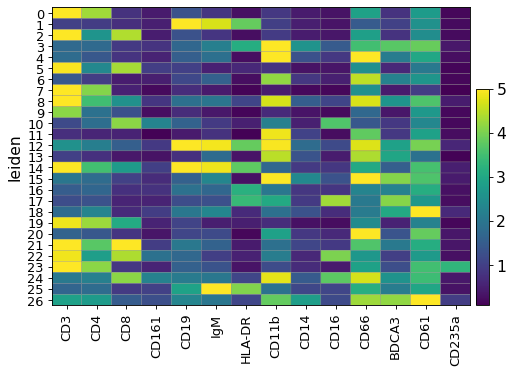

In [110]:
marker_genes = ['CD3', 'CD4', 'CD8', 'CD161', 'CD19', 'IgM', 'HLA-DR', 'CD11b', 'CD14', 'CD16', 'CD66', 'BDCA3', 'CD61', 'CD235a']
gs = sc.pl.matrixplot(adata,marker_genes, groupby='leiden', figsize=(7,5), vmax=5)

In [111]:
labmap = {'0':'Th 1', '1':'B 1', '2':'Tc 1', '3':'Mono/DC 1',
          '4':'Neut 1', '5':'Tc 2', '6':'Neut 2', '7':'Th 2', 
          '8':'T/Neut_doublet 1', '9':'T_low 1', '10':'NK 1', '11':'Neut 3',
          '12':'B/Neut_doublet', '13':'Neut 4', '14':'B/T_doublet',
          '15':'Neut 5', '16':'HLA-DR_high 1', '17':'Mono/DC 2',
          '18':'Platelet', '19': 'Th 3', '20':'Neut 6',
         '21':'Tc 3', '22':'NK/T_doublet', 
         '23':'Th 4', '24':'NK/Neut_doublet',  
          '25':'Plasmablast',
          '26':'Th/Neut/B/Mono_multiplet 1'}



In [112]:
adata.obs['leiden_lab'] = adata.obs['leiden'].replace(labmap)

In [113]:
adata.obs['leiden_lab_group'] = adata.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


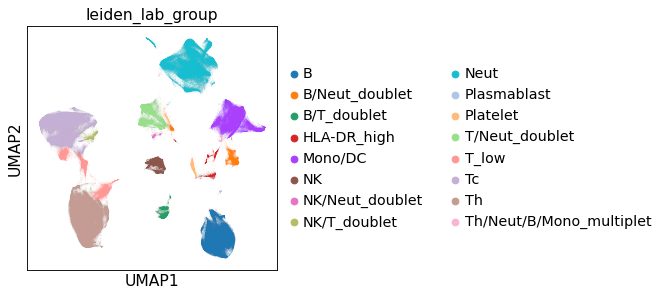

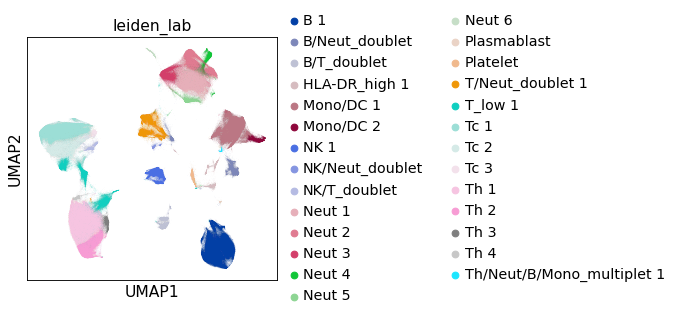

In [114]:
sc.pl.umap(adata, color=['leiden_lab_group'])
sc.pl.umap(adata, color=['leiden_lab'])

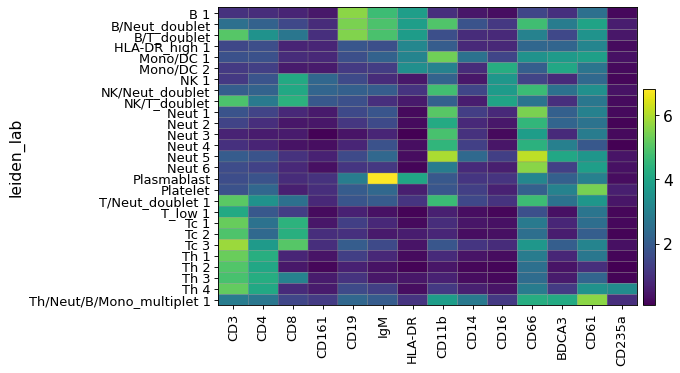

In [115]:
marker_genes = ['CD3', 'CD4', 'CD8', 'CD161', 'CD19', 'IgM', 'HLA-DR', 'CD11b', 'CD14', 'CD16', 'CD66', 'BDCA3', 'CD61', 'CD235a']
gs = sc.pl.matrixplot(adata,marker_genes, groupby='leiden_lab', figsize=(7,5))

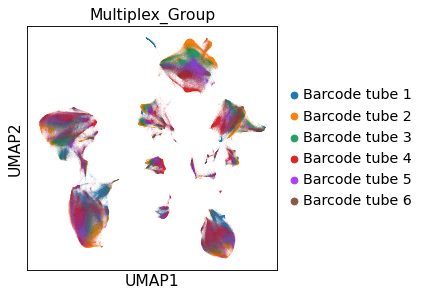

In [116]:
sc.pl.umap(adata, color=['Multiplex_Group'])

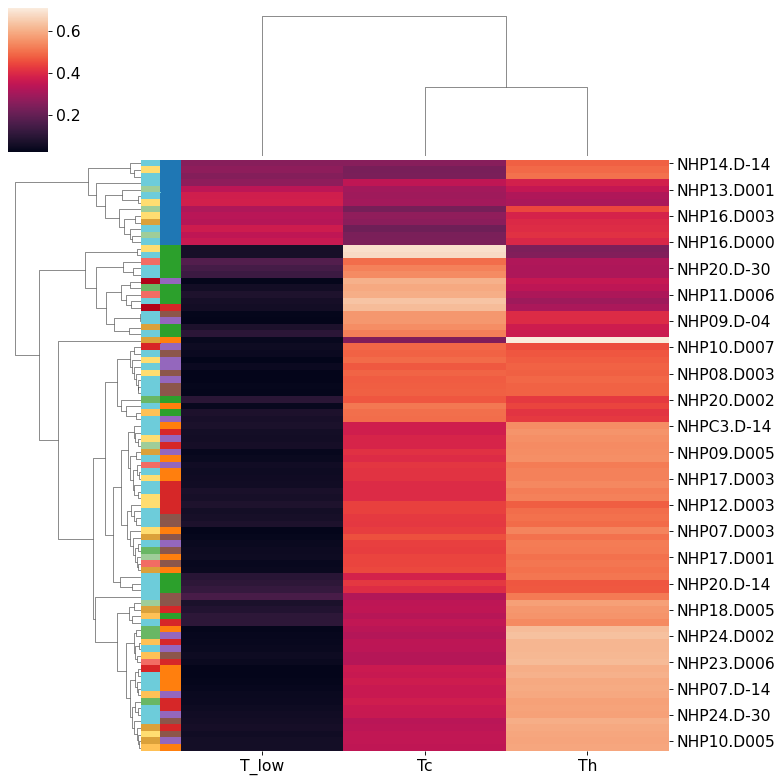

In [117]:
res = {}
for (k,g) in adata.obs.groupby('sample'):
    vc = g['leiden_lab_group'].value_counts()
    vc = vc.loc[['Tc', 'Th', 'T_low']]
    res[k] = vc.div(vc.sum())
    
    
res = pd.DataFrame.from_dict(res).T

dpic = np.array([int(x.split('.')[1][1:]) for x in res.index])
dpic[dpic<0]=0
dpi_color = [dpimap[str(x)] for x in dpic]
X = adata.obs[['sample', 'Multiplex_Group']].drop_duplicates()
samp2group = dict(zip(X['sample'], X['Multiplex_Group'].apply(lambda x: x.split(' ')[-1])))
multiplex_color = [palettable.tableau.Tableau_10.hex_colors[int(samp2group[x])-1] for x in res.index]
sns.clustermap(res.astype(float), row_colors=[dpi_color,multiplex_color])

### Suggests that the T low cluster is an artifact and is enriched for a specific  multiplex group

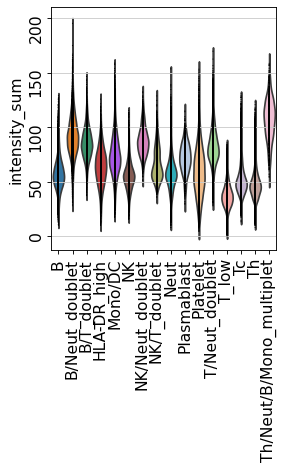

In [104]:
sc.pl.violin(adata, keys=['intensity_sum'], groupby='leiden_lab_group', rotation=90, jitter=False)

In [105]:
list(adata.obs['leiden_lab_group'].unique())

['Mono/DC',
 'NK',
 'B',
 'Platelet',
 'Neut',
 'Tc',
 'T/Neut_doublet',
 'HLA-DR_high',
 'Th',
 'B/Neut_doublet',
 'NK/Neut_doublet',
 'T_low',
 'NK/T_doublet',
 'B/T_doublet',
 'Plasmablast',
 'Th/Neut/B/Mono_multiplet']

In [106]:
adata.obs['is_doublet'] = adata.obs['leiden_lab_group'].apply(lambda x: ('doublet' in x) or ('multiplet' in x))
pd.crosstab(adata.obs['leiden_lab_group'], adata.obs['is_doublet'])

is_doublet                 False  True 
leiden_lab_group                       
B                         158659      0
B/Neut_doublet                 0  22933
B/T_doublet                    0  18918
HLA-DR_high                12839      0
Mono/DC                   102773      0
NK                         34621      0
NK/Neut_doublet                0   2616
NK/T_doublet                   0   5378
Neut                      215304      0
Plasmablast                 1335      0
Platelet                    9381      0
T/Neut_doublet                 0  50978
T_low                      45034      0
Tc                        191513      0
Th                        226514      0
Th/Neut/B/Mono_multiplet       0   1204

... storing 'is_doublet' as categorical


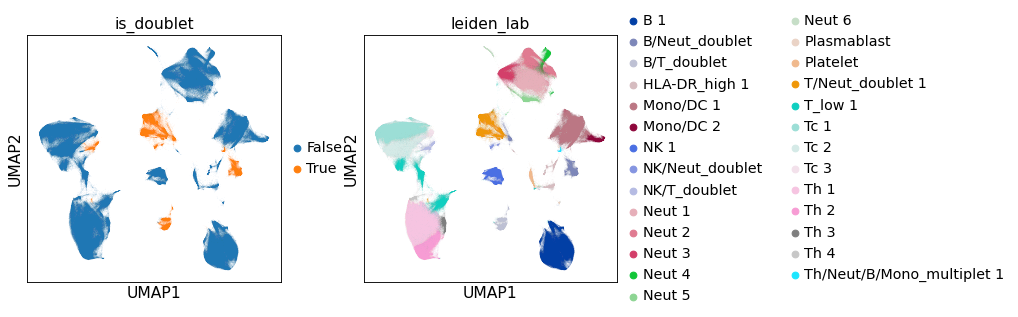

In [107]:
sc.pl.umap(adata, color=['is_doublet', 'leiden_lab'])

In [ ]:
sample_file2 = os.path.join(adir, project_name + '.UMAP.Leiden.h5ad')

In [ ]:
save_adata(adata, sample_file2, ext='.h5ad', gcs=gcs)

In [103]:
adata = read_adata(sample_file2, ext='.h5ad', gcs=gcs)

Only considering the two last: ['.Leiden', '.h5ad'].
Only considering the two last: ['.Leiden', '.h5ad'].


<a id="filter_doublets_RBC_Tlow"></a>
## Filter doublets, RBC, and Tlow cluster

In [96]:
adata

AnnData object with n_obs × n_vars = 1100000 × 42 
    obs: 'samp', 'animal', 'DPI', 'context', 'Time', 'Event_length', 'Pd102Di_BC1', 'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5', 'Pd110Di_BC6', 'Sn120Di_Environ', 'I127Di_127I', 'Xe131Di_Environ', 'Cs133Di_Environ', 'Ba138Di_Ba138Di', 'Pb208Di_Environ', 'BCKG190Di_CKG', 'Center', 'Offset', 'Width', 'Residual', 'DNA1', 'DNA2', 'DPIc', 'Period', 'sum_intensity', 'intensity_sum', 'DNA1_Norm', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'n_counts', 'n_genes', 'sample', 'Multiplex_Group', 'Multiplex_Barcode', 'clinical_score', 'num', 'leiden', 'leiden_lab', 'leiden_lab_group', 'is_doublet'
    var: 'gene_symbol', 'metal', 'full_id'
    uns: 'DPIc_colors', 'Multiplex_Group_colors', 'is_doublet_colors', 'leiden', 'leiden_colors', 'leiden_lab_colors', 'leiden_lab_group_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [97]:
adata.obs['leiden_lab_group'].value_counts()

Th                          226514
Neut                        215304
Tc                          191513
B                           158659
Mono/DC                     102773
T/Neut_doublet               50978
T_low                        45034
NK                           34621
B/Neut_doublet               22933
B/T_doublet                  18918
HLA-DR_high                  12839
Platelet                      9381
NK/T_doublet                  5378
NK/Neut_doublet               2616
Plasmablast                   1335
Th/Neut/B/Mono_multiplet      1204
Name: leiden_lab_group, dtype: int64

In [98]:
tofilter = adata.obs['leiden_lab_group'].isin(['T_low']) | (adata.obs['is_doublet']=='True')

In [99]:
pd.crosstab(tofilter, adata.obs['leiden_lab_group'])

leiden_lab_group       B  B/Neut_doublet  B/T_doublet  HLA-DR_high  Mono/DC  \
row_0                                                                         
False             158659               0            0        12839   102773   
True                   0           22933        18918            0        0   

leiden_lab_group     NK  NK/Neut_doublet  NK/T_doublet    Neut  Plasmablast  \
row_0                                                                         
False             34621                0             0  215304         1335   
True                  0             2616          5378       0            0   

leiden_lab_group  Platelet  T/Neut_doublet  T_low      Tc      Th  \
row_0                                                               
False                 9381               0      0  191513  226514   
True                     0           50978  45034       0       0   

leiden_lab_group  Th/Neut/B/Mono_multiplet  
row_0                                       
False                                    0  
True                                  1204

In [100]:
adata = adata[~tofilter, :]

In [101]:
adata.obs['leiden_lab_group'].value_counts()

Th             226514
Neut           215304
Tc             191513
B              158659
Mono/DC        102773
NK              34621
HLA-DR_high     12839
Platelet         9381
Plasmablast      1335
Name: leiden_lab_group, dtype: int64

Trying to set attribute `.uns` of view, copying.


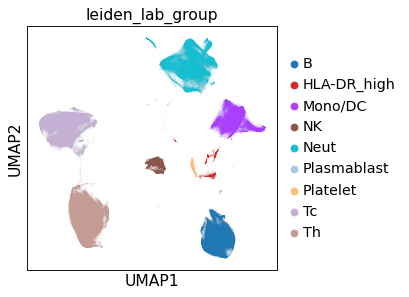

In [102]:
sc.pl.umap(adata, color=['leiden_lab_group'])


<a id="batch_per_celltype"></a>
## COMBAT batch correction per cell-type

In [89]:
adata_corrected = []
for c in list(adata.obs['leiden_lab_group'].unique()):
    ind = adata.obs.index[adata.obs['leiden_lab_group']==c]
    Z = adata[ind,:]
    sc.pp.combat(Z, key='Multiplex_Group', inplace=True)
    adata_corrected.append(Z.copy())

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:269: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_it_sol" failed type inference due to: Cannot unify array(float64, 2d, C) and array(float64, 1d, C) for 'sum2', defined at /opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (311)

File "../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py", line 311:
def _it_sol(s_data, g_hat, d_hat, g_bar, t2, a, b, conv=0.0001) -> Tuple[float, float]:
    <source elided>
        g_new = (t2*n*g_hat + d_old*g_bar) / (t2*n + d_old)
        sum2 = s_data - g_new.reshape((g_new.shape[0], 1)) @ np.ones((1, s_data.shape[1]))
        ^

[1] During: typing of assignment at /opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (313)

File "../../../../../../../../../../opt/minicond

In [90]:
adata_corrected = adata_corrected[0].concatenate(adata_corrected[1:])

In [118]:
sample_file3 = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.h5ad')

In [92]:
adata_corrected

AnnData object with n_obs × n_vars = 952939 × 42 
    obs: 'BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1', 'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI', 'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode', 'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1', 'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5', 'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width', 'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context', 'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample', 'sum_intensity'
    var: 'gene_symbol', 'metal', 'full_id'
    obsm: 'X_pca', 'X_umap'

In [93]:
save_adata(adata_corrected, sample_file3, ext='.h5ad', gcs=gcs)

Only considering the two last: ['.COMBAT', '.h5ad'].
Only considering the two last: ['.COMBAT', '.h5ad'].


... storing 'leiden' as categorical
... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical
... storing 'num' as categorical
... storing 'samp' as categorical
... storing 'sample' as categorical


In [119]:
adata = read_adata(sample_file3, ext='.h5ad', gcs=gcs)

Only considering the two last: ['.COMBAT', '.h5ad'].
Only considering the two last: ['.COMBAT', '.h5ad'].


In [120]:
adata

AnnData object with n_obs × n_vars = 952939 × 42 
    obs: 'BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1', 'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI', 'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode', 'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1', 'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5', 'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width', 'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context', 'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample', 'sum_intensity'
    var: 'gene_symbol', 'metal', 'full_id'
    obsm: 'X_pca', 'X_umap'

<a id="clustering2"></a>
## Can optionally repeat clustering after COMBAT before cNMF

<a id="cNMF"></a>
## Run cNMF and regress out platelet / fixation artifact

In [121]:
adata_noneg = adata.copy()
adata_noneg.X[adata_noneg.X<0]=0

In [122]:
cnmfdir = os.path.join(adir, 'cNMF')
if not os.path.exists(cnmfdir):
    os.mkdir(cnmfdir)

In [123]:
hvgfn = os.path.join(cnmfdir, 'hvgs.txt')
with open(hvgfn, 'w') as F:
    F.write('\n'.join(adata_noneg.var.index))

In [124]:
adata_noneg_fn = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.NoNegative.h5ad')
adata_noneg_fn_npz = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.NoNegative.npz')


In [125]:
adata_noneg.uns = {}
adata_noneg.obsm = None
adata_noneg.varm = None

In [126]:
sc.write(adata_noneg_fn, adata_noneg)

Only considering the two last: ['.NoNegative', '.h5ad'].
Only considering the two last: ['.NoNegative', '.h5ad'].


In [127]:
adata_noneg

AnnData object with n_obs × n_vars = 952939 × 42 
    obs: 'BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1', 'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI', 'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode', 'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1', 'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5', 'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width', 'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context', 'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample', 'sum_intensity'
    var: 'gene_symbol', 'metal', 'full_id'

In [128]:
X = pd.DataFrame(adata_noneg.X, index=adata_noneg.obs.index, columns=adata_noneg.var.index)
save_df_to_npz(X, adata_noneg_fn_npz)
del(X)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numpy/lib/format.py:356: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)


In [129]:
## This needs to be run from the cnmf_env environment in the command line
NAME = project_name + '.DoubletFilt.COMBAT.NoNegative'
OUTDIR = cnmfdir
COUNT = adata_noneg_fn
HVG = hvgfn
SEED = 14
NITER = 20
Ks = ' '.join([str(x) for x in range(6,16)])
NUMWORKERS = 100

if not os.path.exists(OUTDIR):
    os.mkdir(OUTDIR)

cmd = 'python ../../../Code/cNMF/cnmf_nonorm.py prepare --name {NAME} --output-dir {OUTDIR} \
-c {COUNT} -k {Ks} -n {NITER} --seed {SEED} --genes-file {HVG} --total-workers {NUMWORKERS} --beta-loss frobenius --tpm {COUNT}'.format(NAME=NAME, OUTDIR=OUTDIR, COUNT=adata_noneg_fn_npz, Ks=Ks, NITER=NITER, SEED=SEED, HVG=HVG, NUMWORKERS=NUMWORKERS)
print(cmd)
#!{cmd}

python ../../../Code/cNMF/cnmf_nonorm.py prepare --name Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative --output-dir ../../../../data/InVivo/Cytof/cNMF -c ../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative.npz -k 6 7 8 9 10 11 12 13 14 15 -n 20 --seed 14 --genes-file ../../../../data/InVivo/Cytof/cNMF/hvgs.txt --total-workers 100 --beta-loss frobenius --tpm ../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative.npz


In [131]:
gs_cnmf_dir = 'gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF/'


In [132]:
cmd = 'gsutil -m cp -r %s %s' % (os.path.join(OUTDIR, NAME), gs_cnmf_dir)
print(cmd)
!{cmd}

gsutil -m cp -r ../../../../data/InVivo/Cytof/cNMF/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF/
/snap/google-cloud-sdk/129/lib/third_party/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
Copying file://../../../../data/InVivo/Cytof/cNMF/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative.overdispersed_genes.txt [Content-Type=text/plain]...
Copying file://../../../../data/InVivo/Cytof/cNMF/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative/cnmf_tmp/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative.tpm.h5ad [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite u

In [133]:
gs_cnmf_dir = 'gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF'
INDIR = gs_cnmf_dir
OUTDIRBASE = 'gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF_Temp/results_%s'
CONTAINER = 'quay.io/dkotliar/cnmf:0.2'

if not os.path.exists('cNMFsubmit'):
    os.mkdir('cNMFsubmit')

subcmdbase = """dsub --project sabeti-txnomics --zones 'us-central1-c' \
--name {NODENAME} --provider google-v2 --machine-type n1-highmem-4 --boot-disk-size 100 --disk-size 1000 \
--logging {INDIR}/{NAME}/log/ \
--image {CONTAINER} \
--input-recursive INDIR={INDIR} \
--output-recursive OUTDIR={OUTDIR} \
--env NAME={NAME} \
--command '{EXECCMD}'"""

num_nodes = NUMWORKERS
for i in range(num_nodes):
    worker1 = i
    NODENAME = 'node%d' % i
    OUTDIR = OUTDIRBASE % i
    EXECCMD = 'source activate cnmf_env; python /home/cNMF/cnmf.py factorize --output-dir {O} --name {N} --worker-index {W} --total-workers {NW}; mv {O}/{N}/cnmf_tmp/*iter* {F}'.format(O='${INDIR}', N='${NAME}', W=worker1, NW=NUMWORKERS, F='${OUTDIR}')
    SUBCMD = subcmdbase.format(INDIR=INDIR, OUTDIR=OUTDIR, CONTAINER=CONTAINER, EXECCMD=EXECCMD, NODENAME=NODENAME, NAME=NAME)
    
    subfile = os.path.join('cNMFsubmit', 'submit_%d.sh' % i)
    with open(subfile, 'w') as F:
        F.write('#!/bin/bash\n')
        F.write('source ~/.bashrc\n')
        F.write(SUBCMD+'\n')
    ! {'chmod 740 %s' % subfile}
    ! {'bash %s' % subfile}

Job: node0--dkotliar--200505-122323-59
Provider internal-id (operation): projects/sabeti-txnomics/operations/15753746875923266406
Launched job-id: node0--dkotliar--200505-122323-59
To check the status, run:
  dstat --provider google-v2 --project sabeti-txnomics --jobs 'node0--dkotliar--200505-122323-59' --users 'dkotliar' --status '*'
To cancel the job, run:
  ddel --provider google-v2 --project sabeti-txnomics --jobs 'node0--dkotliar--200505-122323-59' --users 'dkotliar'
node0--dkotliar--200505-122323-59
Job: node1--dkotliar--200505-122324-67
Provider internal-id (operation): projects/sabeti-txnomics/operations/150555404173587316
Launched job-id: node1--dkotliar--200505-122324-67
To check the status, run:
  dstat --provider google-v2 --project sabeti-txnomics --jobs 'node1--dkotliar--200505-122324-67' --users 'dkotliar' --status '*'
To cancel the job, run:
  ddel --provider google-v2 --project sabeti-txnomics --jobs 'node1--dkotliar--200505-122324-67' --users 'dkotliar'
node1--dkotlia

In [134]:
! gsutil -m mv gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF_Temp/*/*.df.npz gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF/Full_IRF_SerialSac_Cytof.1M.DoubletFilt.COMBAT.NoNegative/cnmf_tmp/

/snap/google-cloud-sdk/129/lib/third_party/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
Copying gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF_Temp/results_0/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative.spectra.k_11.iter_0.df.npz [Content-Type=application/octet-stream]...
Copying gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF_Temp/results_0/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative.spectra.k_6.iter_0.df.npz [Content-Type=application/octet-stream]...
Copying gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF_Temp/results_1/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative.spectra.k_11.iter_1.df.npz [Content-Type=application/octet-stream]...
Copying gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analy

In [135]:
! gsutil ls gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF/Full_IRF_SerialSac_Cytof.1M.DoubletFilt.COMBAT.NoNegative/cnmf_tmp/| wc -l

/snap/google-cloud-sdk/129/lib/third_party/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
200


In [136]:
! ! gsutil -m rm -r gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF_Temp

/snap/google-cloud-sdk/129/lib/third_party/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
Removing gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF_Temp/results_0/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative.spectra.k_11.iter_0.df.npz#1588682214574076...
Removing gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF_Temp/results_0/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative.spectra.k_6.iter_0.df.npz#1588682214628679...
Removing gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF_Temp/results_1/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative.spectra.k_11.iter_1.df.npz#1588682259593795...
Removing gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF_Temp/results_1/Full_IRF_SerialSac_Cytof_Fixid.1M.Doublet

In [138]:
fromd = 'gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF/Full_IRF_SerialSac_Cytof.1M.DoubletFilt.COMBAT.NoNegative/cnmf_tmp'
tod = '../../../../data/InVivo/Cytof/cNMF/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative/cnmf_tmp'
cmd = 'gsutil -m rsync %s %s' % (fromd, tod)
print(cmd)
!{cmd}

gsutil -m rsync gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF/Full_IRF_SerialSac_Cytof.1M.DoubletFilt.COMBAT.NoNegative/cnmf_tmp ../../../../data/InVivo/Cytof/cNMF/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative/cnmf_tmp
/snap/google-cloud-sdk/129/lib/third_party/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
Building synchronization state...
Starting synchronization...
Copying gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF/Full_IRF_SerialSac_Cytof.1M.DoubletFilt.COMBAT.NoNegative/cnmf_tmp/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative.spectra.k_10.iter_0.df.npz...
Copying gs://seqwell/data/Analysis/Data_Freeze_20190829_Clean/InVivo/Cytof/Analysis/cNMF/Full_IRF_SerialSac_Cytof.1M.DoubletFilt.COMBAT.NoNegative/cnmf_tmp/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.

In [139]:
NAME = project_name + '.DoubletFilt.COMBAT.NoNegative'
OUTDIR = cnmfdir

cmd = 'python ../../../Code/cNMF/cnmf_nonorm.py combine --name {NAME} --output-dir {OUTDIR}'.format(NAME=NAME, OUTDIR=OUTDIR)
print(cmd)
!{cmd}

python ../../../Code/cNMF/cnmf_nonorm.py combine --name Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative --output-dir ../../../../data/InVivo/Cytof/cNMF
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining facto

In [140]:
cmd = 'rm %s' % os.path.join(OUTDIR, NAME, 'cnmf_tmp/*.iter_*')
!{cmd}

In [141]:
cmd = 'python ../../../Code/cNMF/cnmf_nonorm.py k_selection_plot --name {NAME} --output-dir {OUTDIR}'.format(NAME=NAME, OUTDIR=OUTDIR)
print(cmd)
!{cmd}

python ../../../Code/cNMF/cnmf_nonorm.py k_selection_plot --name Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative --output-dir ../../../../data/InVivo/Cytof/cNMF
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Only considering the two last: ['.norm_counts', '.h5ad'].
Only considering the two last: ['.norm_counts', '.

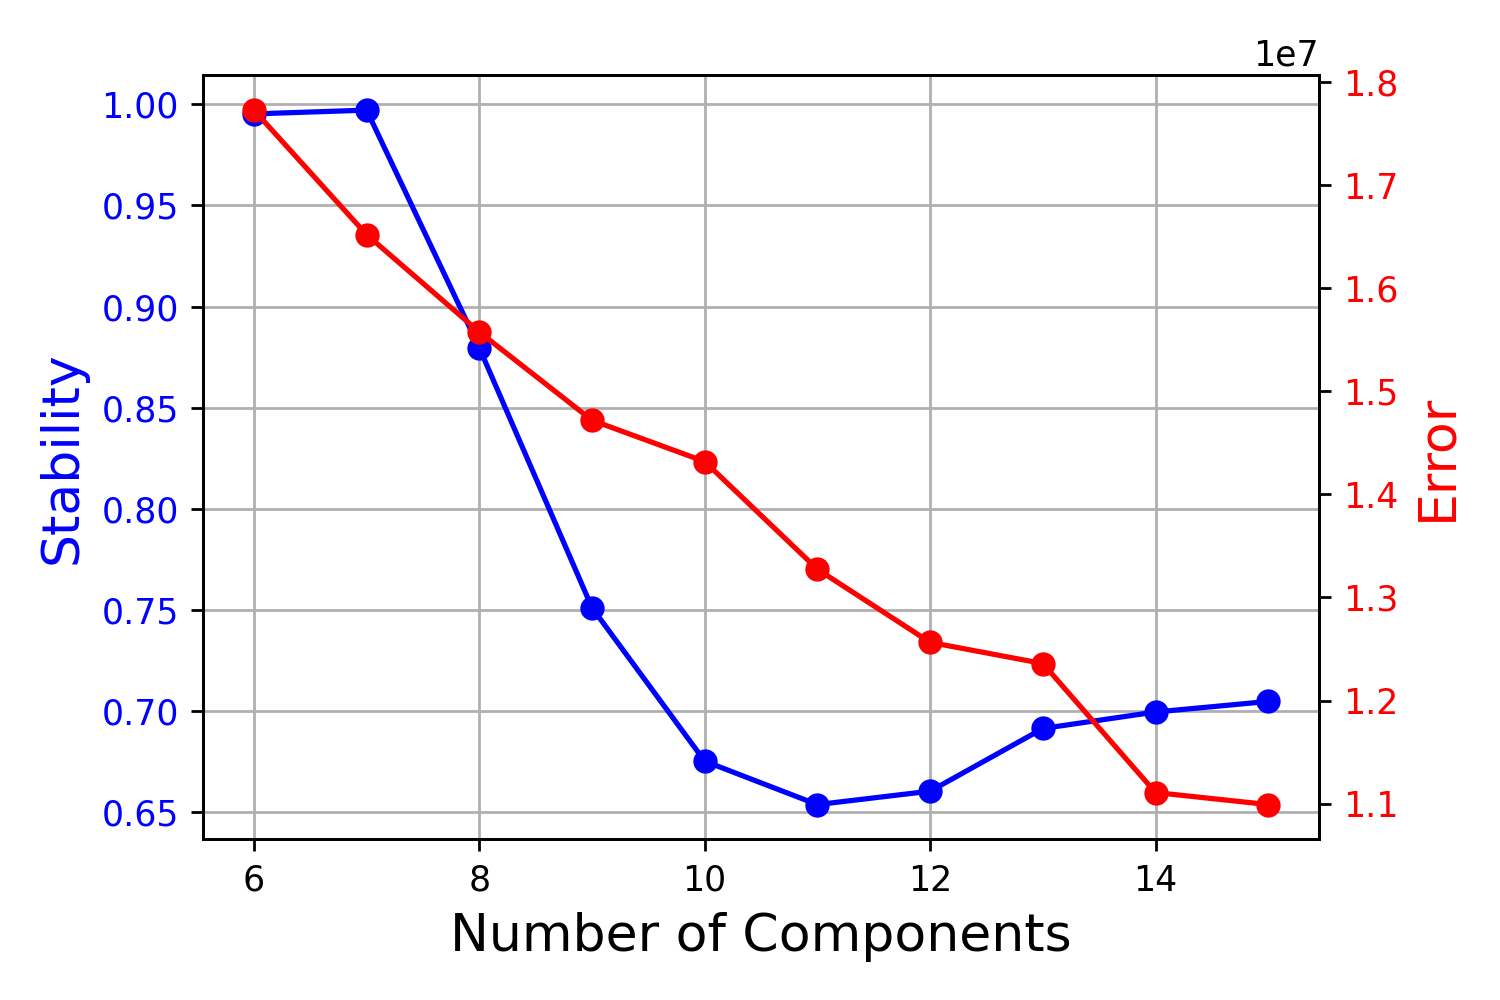

In [142]:
from IPython.display import Image
image_fn = os.path.join(OUTDIR, NAME, NAME+".k_selection.png")
Image(filename = image_fn,
      width=1000, height=1000)

In [143]:
selected_K = 7
density_threshold = 2.00
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')


In [144]:
cmd = 'python ../../../Code/cNMF/cnmf_nonorm.py consensus -k %d --name %s --output-dir %s --local-density-threshold %.2f --show-clustering' % (selected_K, NAME, OUTDIR, density_threshold)
print(cmd)
!{cmd}

python ../../../Code/cNMF/cnmf_nonorm.py consensus -k 7 --name Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.NoNegative --output-dir ../../../../data/InVivo/Cytof/cNMF --local-density-threshold 2.00 --show-clustering
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Only considering the two last: ['.norm_counts', '.h5ad'].
Onl

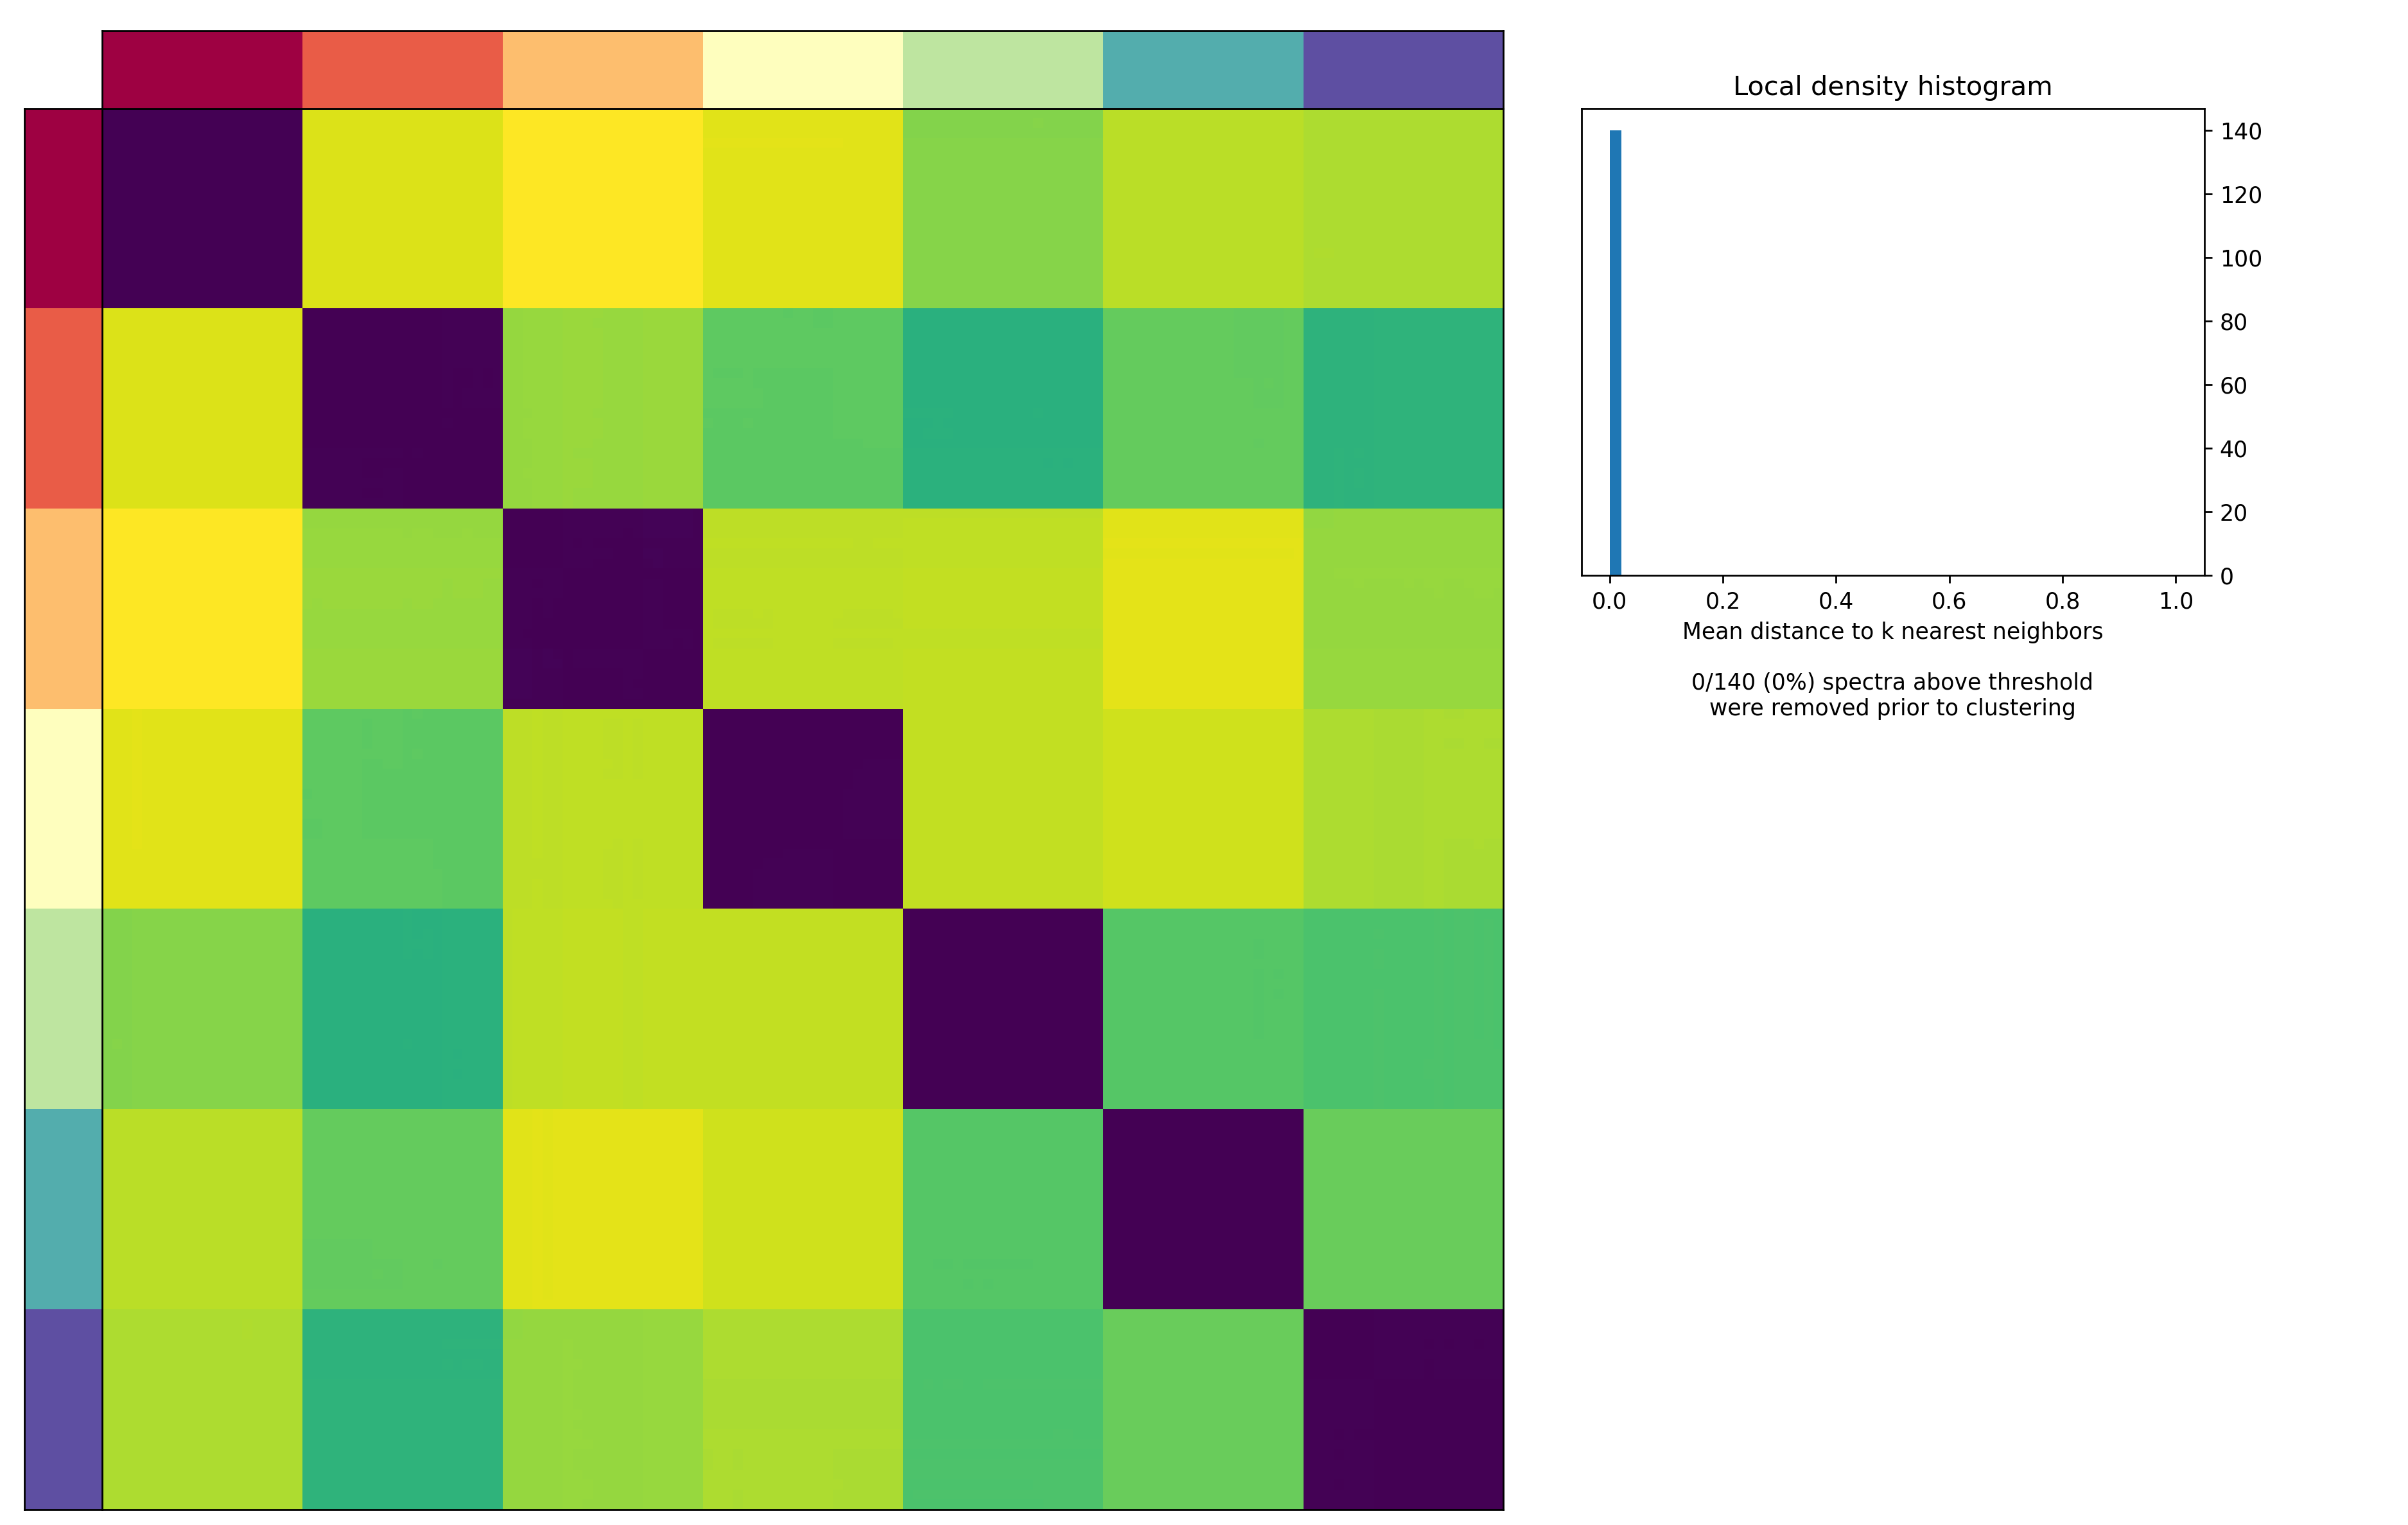

In [145]:
consensus_plot_fn = os.path.join(OUTDIR, NAME, NAME+".clustering.k_%d.dt_%s.png" % (selected_K, density_threshold_str))
Image(filename = consensus_plot_fn,
      width=1000, height=1000)

In [146]:
component_fn = os.path.join(OUTDIR, NAME, NAME+".gene_spectra_score.k_%d.dt_%s.txt" % (selected_K, density_threshold_str))
components = pd.read_csv(component_fn,
                     sep='\t', index_col=0).T

topgenes = []
topscores = []
for c in components.columns:
    topgenes.append(components.sort_values(by=c, ascending=False).index[:20])
    topscores.append(components[c].sort_values(ascending=False).values[:20])
topgenes = pd.DataFrame(topgenes).T
topscores = pd.DataFrame(topscores).T
topgenes.columns = components.columns
topscores.columns = topscores.columns

topgenes.head(10)

1         2         3       4       5       6       7
0   CD161      CD66      CD61    Ki67     CD3    CD19   STAT1
1    CD16     CD11b      CD33   STAT4     CD4    CD1c    CD14
2    CD38  Zap70Syk    CD235a    TBK1    CD45     IgM   BDCA3
3     CD8     Erk12     STAT3  Fox_P3    CD27  HLA-DR   CD11c
4    CD27      CD33       CD7   STAT6     CD7    IkBa   CD11b
5   CD11c        S6     CD123    CREB     CD8    CD38  HLA-DR
6     CD7      CD14     PLCg2     P38    CD66   4EBP1    CD16
7  Fox_P3      CCR7    CD45RA   STAT5  CD235a   CD11c    CD56
8    CD45     BDCA3     BDCA3   4EBP1   STAT1    CD45    CD45
9  CD45RA     STAT5  MAPKAPK2   Erk12    CD38  CD235a   CD123

In [147]:
usage_fn = os.path.join(OUTDIR, NAME, NAME+".usages.k_%d.dt_%s.consensus.txt" % (selected_K, density_threshold_str))

usage = pd.read_csv(usage_fn, sep='\t', index_col=0)
usage.columns = ['Usage_%s' % i for i in usage.columns]
usage_norm = usage.div(usage.sum(axis=1), axis=0)
usage_norm.head()

Usage_1   Usage_2   Usage_3   Usage_4   Usage_5  \
index                                                                        
NHP07.D003.LIVE_34361-0   0.135881  0.058617  0.015487  0.206003  0.000000   
NHP07.D003.LIVE_116133-0  0.074207  0.186093  0.190032  0.160167  0.000000   
NHP07.D003.LIVE_117138-0  0.003071  0.294525  0.113868  0.090186  0.088690   
NHP07.D003.LIVE_94776-0   0.024425  0.144916  0.129960  0.336414  0.075244   
NHP07.D003.LIVE_69626-0   0.057282  0.093952  0.017669  0.269710  0.031618   

                           Usage_6   Usage_7  
index                                         
NHP07.D003.LIVE_34361-0   0.090974  0.493038  
NHP07.D003.LIVE_116133-0  0.063399  0.326102  
NHP07.D003.LIVE_117138-0  0.071405  0.338255  
NHP07.D003.LIVE_94776-0   0.125462  0.163579  
NHP07.D003.LIVE_69626-0   0.077190  0.452578

In [148]:
overlap = list(set(usage_norm.columns).intersection(set(adata.obs.columns)))
adata.obs.drop(overlap, axis=1, inplace=True)

In [149]:
adata.obs = pd.merge(left=adata.obs, right=usage_norm, how='left', left_index=True, right_index=True)

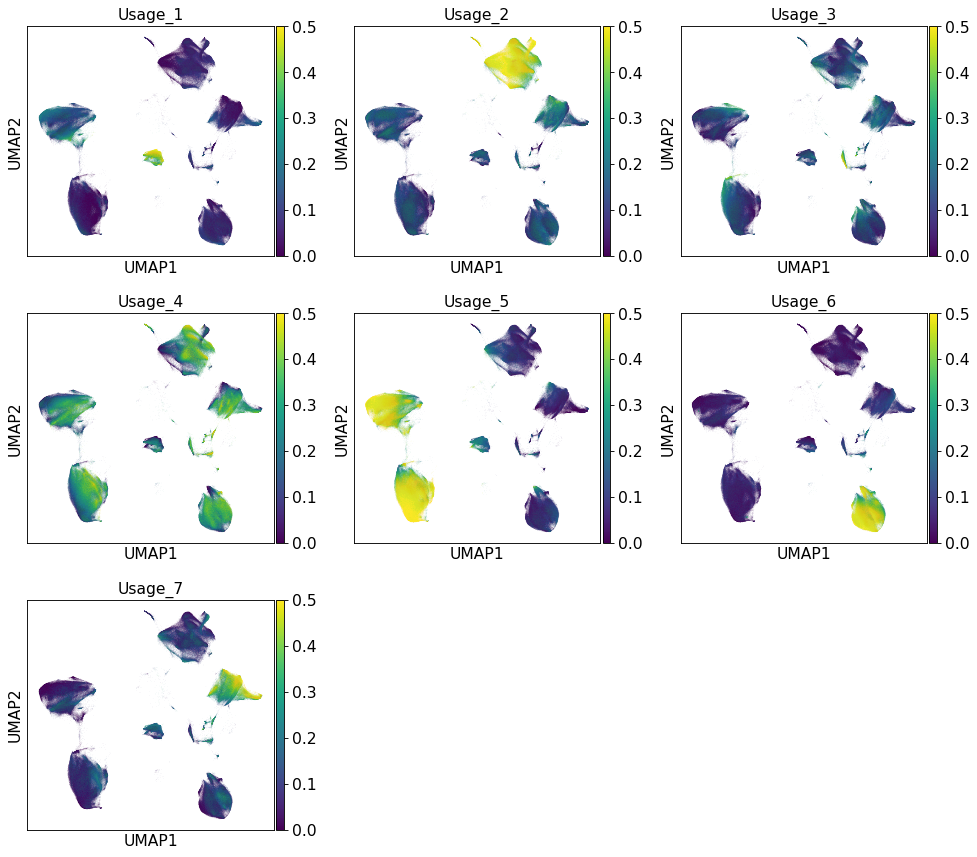

In [150]:
sc.pl.umap(adata, color=usage_norm.columns, ncols=3, vmin=0, vmax=.5)

In [151]:
adata_noneg = read_adata(adata_noneg_fn, gcs=gcs)

Only considering the two last: ['.NoNegative', '.h5ad'].
Only considering the two last: ['.NoNegative', '.h5ad'].


In [152]:
spec_fn = os.path.join(OUTDIR, NAME, NAME+".spectra.k_%d.dt_%s.consensus.txt" % (selected_K, density_threshold_str))

spec = pd.read_csv(spec_fn, sep='\t', index_col=0)
spec.head()

CD27      CD61      TBK1      CD1c      IkBa     BDCA3    CD45RA  \
1  0.072814  0.004303  0.018262  0.000000  0.000000  0.001600  0.032546   
2  0.001135  0.035522  0.014832  0.000603  0.000000  0.030124  0.001100   
3  0.023780  0.127910  0.002334  0.000000  0.000000  0.041746  0.045873   
4  0.000000  0.015952  0.063724  0.003063  0.038199  0.010771  0.031275   
5  0.051111  0.036796  0.010696  0.000000  0.012821  0.000000  0.001235   

     Fox_P3     CD161     STAT4  ...     Erk12       P38      CD16      Ki67  \
1  0.038376  0.130459  0.020483  ...  0.007917  0.000844  0.104241  0.024017   
2  0.011134  0.000000  0.019473  ...  0.063806  0.029886  0.004748  0.006237   
3  0.000340  0.005093  0.000925  ...  0.016529  0.017873  0.000000  0.000000   
4  0.062722  0.016628  0.061487  ...  0.043740  0.052848  0.000000  0.064951   
5  0.003430  0.000000  0.000000  ...  0.026022  0.013349  0.000000  0.007854   

       CD38      CCR7     4EBP1      CD19       IgM  HLA-DR  
1  0.104476  0.035183  0.005443  0.014536  0.004683     0.0  
2  0.000000  0.091416  0.038664  0.010957  0.020976     0.0  
3  0.021488  0.006799  0.000000  0.006034  0.024058     0.0  
4  0.000000  0.045474  0.043415  0.002957  0.000000     0.0  
5  0.014983  0.088099  0.004762  0.011177  0.000477     0.0  

[5 rows x 42 columns]

In [153]:
usage = pd.read_csv(usage_fn, sep='\t', index_col=0)
usage.columns = np.arange(1,selected_K+1)
usage.head()


1          2          3          4  \
index                                                                  
NHP07.D003.LIVE_34361-0   10.911849   4.707157   1.243638  16.542938   
NHP07.D003.LIVE_116133-0   6.599473  16.549742  16.900036  14.244074   
NHP07.D003.LIVE_117138-0   0.211742  20.306819   7.850941   6.218099   
NHP07.D003.LIVE_94776-0    2.183616  12.955684  11.618545  30.075867   
NHP07.D003.LIVE_69626-0    4.604693   7.552465   1.420325  21.680911   

                                 5          6          7  
index                                                     
NHP07.D003.LIVE_34361-0   0.000000   7.305603  39.593046  
NHP07.D003.LIVE_116133-0  0.000000   5.638223  29.001167  
NHP07.D003.LIVE_117138-0  6.114962   4.923189  23.321903  
NHP07.D003.LIVE_94776-0   6.726928  11.216431  14.624164  
NHP07.D003.LIVE_69626-0   2.541663   6.205038  36.381031

In [154]:
geps_to_regress = [3,4]

In [155]:
adata_noneg.X = adata_noneg.X - usage.loc[:, geps_to_regress].dot(spec.loc[geps_to_regress, :]).values

In [156]:
order = sorted(adata.obs['leiden_lab'].unique())

[Text(0, 0, 'B 1'),
 Text(0, 0, 'HLA-DR_high 1'),
 Text(0, 0, 'Mono/DC 1'),
 Text(0, 0, 'Mono/DC 2'),
 Text(0, 0, 'NK 1'),
 Text(0, 0, 'Neut 1'),
 Text(0, 0, 'Neut 2'),
 Text(0, 0, 'Neut 3'),
 Text(0, 0, 'Neut 4'),
 Text(0, 0, 'Neut 5'),
 Text(0, 0, 'Neut 6'),
 Text(0, 0, 'Plasmablast'),
 Text(0, 0, 'Platelet'),
 Text(0, 0, 'Tc 1'),
 Text(0, 0, 'Tc 2'),
 Text(0, 0, 'Tc 3'),
 Text(0, 0, 'Th 1'),
 Text(0, 0, 'Th 2'),
 Text(0, 0, 'Th 3'),
 Text(0, 0, 'Th 4')]

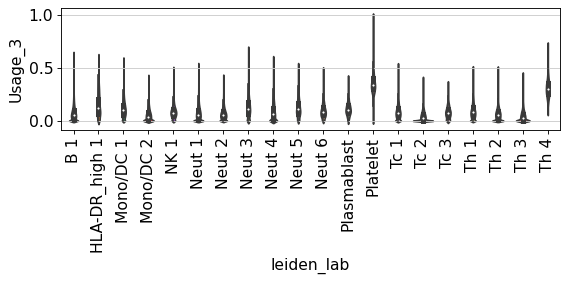

In [157]:
(fig,ax) = plt.subplots(1,1, figsize=(8,2))
sns.violinplot(x='leiden_lab', y='Usage_3', data=adata.obs, ax=ax, order=order)
ax.set_xticklabels(order, rotation=90)

[Text(0, 0, 'B 1'),
 Text(0, 0, 'HLA-DR_high 1'),
 Text(0, 0, 'Mono/DC 1'),
 Text(0, 0, 'Mono/DC 2'),
 Text(0, 0, 'NK 1'),
 Text(0, 0, 'Neut 1'),
 Text(0, 0, 'Neut 2'),
 Text(0, 0, 'Neut 3'),
 Text(0, 0, 'Neut 4'),
 Text(0, 0, 'Neut 5'),
 Text(0, 0, 'Neut 6'),
 Text(0, 0, 'Plasmablast'),
 Text(0, 0, 'Platelet'),
 Text(0, 0, 'Tc 1'),
 Text(0, 0, 'Tc 2'),
 Text(0, 0, 'Tc 3'),
 Text(0, 0, 'Th 1'),
 Text(0, 0, 'Th 2'),
 Text(0, 0, 'Th 3'),
 Text(0, 0, 'Th 4')]

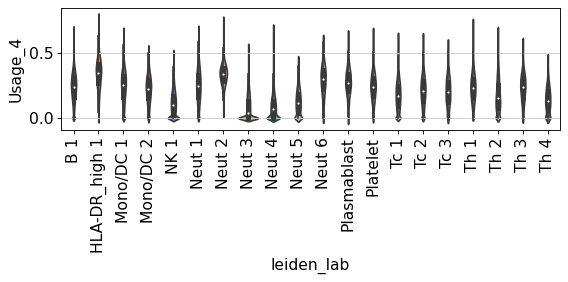

In [158]:
(fig,ax) = plt.subplots(1,1, figsize=(8,2))
sns.violinplot(x='leiden_lab', y='Usage_4', data=adata.obs, ax=ax, order=order)
ax.set_xticklabels(order, rotation=90)

In [159]:
ind = (adata_noneg.obs['leiden_lab_group'] !='Platelet')
adata_noneg = adata_noneg[ind,:]

In [160]:
sample_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.h5ad')
sample_file

'../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.h5ad'

In [161]:
save_adata(adata_noneg, sample_file, ext='.h5ad', gcs=gcs)

Only considering the two last: ['.SubtractCNMF', '.h5ad'].
Only considering the two last: ['.SubtractCNMF', '.h5ad'].


<a id="clustering3"></a>
## Run next iteration of clustering on the COMBAT / cNMF corrected data

In [162]:
adata = adata_noneg

In [163]:
pca_cytof(adata)

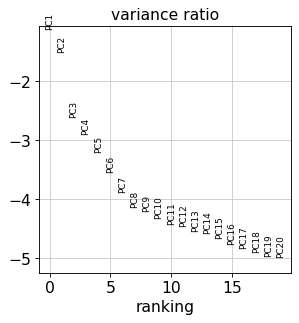

In [164]:
sc.pl.pca_variance_ratio(adata, log=True)

In [165]:
adata

AnnData object with n_obs × n_vars = 943558 × 42 
    obs: 'BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1', 'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI', 'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode', 'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1', 'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5', 'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width', 'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context', 'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample', 'sum_intensity'
    var: 'gene_symbol', 'metal', 'full_id'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

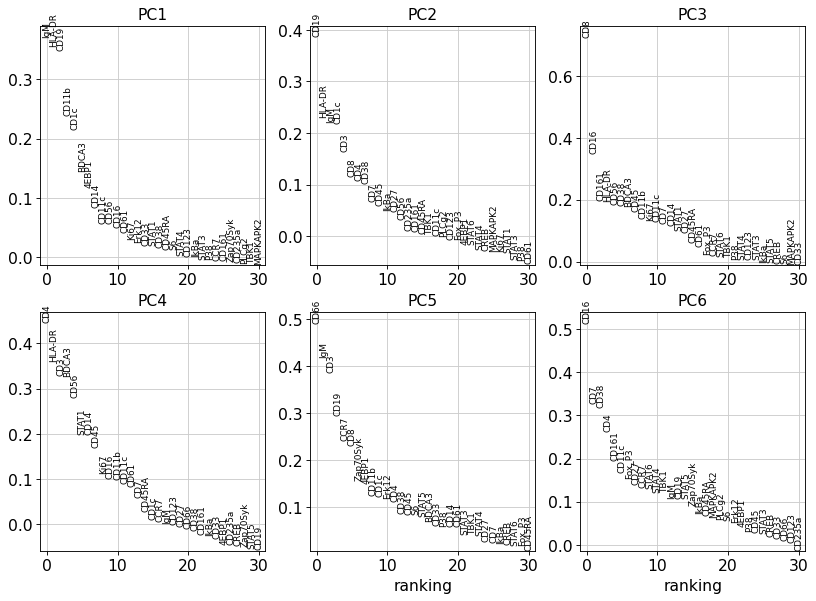

In [166]:
sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6])

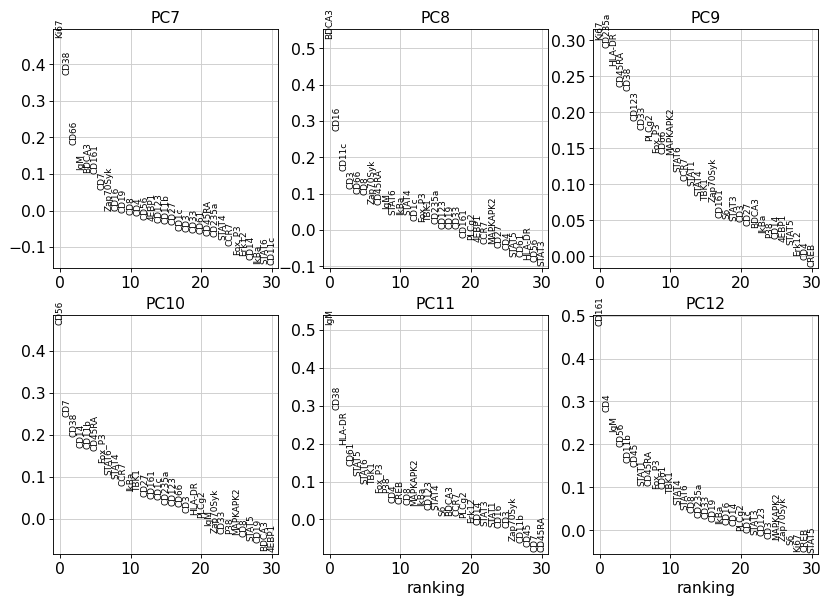

In [167]:
sc.pl.pca_loadings(adata, components=[7,8,9,10,11,12])

In [168]:
adata

AnnData object with n_obs × n_vars = 943558 × 42 
    obs: 'BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1', 'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI', 'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode', 'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1', 'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5', 'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width', 'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context', 'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample', 'sum_intensity'
    var: 'gene_symbol', 'metal', 'full_id'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [169]:
sc.pp.neighbors(adata, n_neighbors=int(adata.shape[0]*.0001), n_pcs=18, random_state=14)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [170]:
sc.tl.umap(adata, min_dist=0.1, spread=2.0)

In [6]:
sample_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.h5ad')


In [172]:
save_adata(adata, sample_file, ext='.h5ad', gcs=gcs)


Only considering the two last: ['.UMAP', '.h5ad'].
Only considering the two last: ['.UMAP', '.h5ad'].


In [7]:
adata = read_adata(sample_file, ext='.h5ad', gcs=gcs)


Only considering the two last: ['.UMAP', '.h5ad'].
Only considering the two last: ['.UMAP', '.h5ad'].


In [8]:
adata.obs.columns

Index(['BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1',
       'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI',
       'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode',
       'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1',
       'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5',
       'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width',
       'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context',
       'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab',
       'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample',
       'sum_intensity'],
      dtype='object')

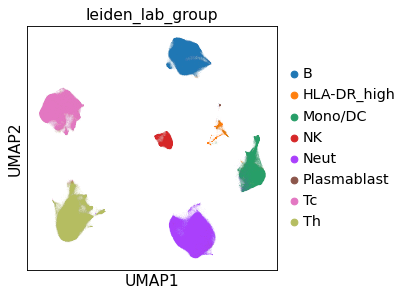

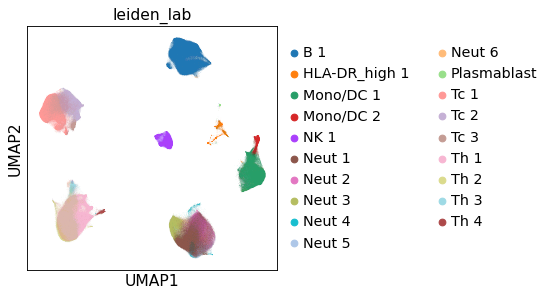

In [9]:
sc.pl.umap(adata, color=['leiden_lab_group'])
sc.pl.umap(adata, color=['leiden_lab'])


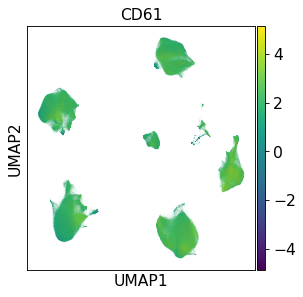

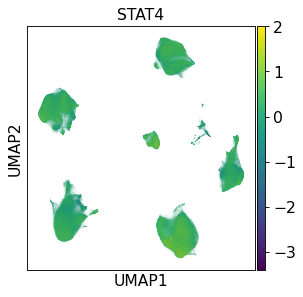

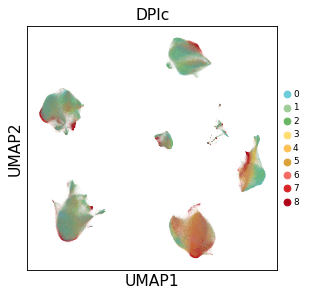

In [10]:

sc.pl.umap(adata, color=['CD61'])
sc.pl.umap(adata, color=['STAT4'], vmax=2)
sc.pl.umap(adata, color=['DPIc'],sort_order=False, alpha=.7,
           palette=[dpimap[str(i)] for i in range(9)], legend_fontsize=8)

In [11]:
sc.tl.leiden(adata, resolution=1.0, random_state=14)

In [12]:
adata.obs['leiden'].value_counts()

0     208541
1     181878
2     163131
3     157899
4      91367
5      51919
6      34636
7      14009
8      13863
9      11337
10      7030
11      6092
12      1361
13       452
14        43
Name: leiden, dtype: int64

In [13]:
sample_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.h5ad')


In [14]:
save_adata(adata, sample_file, ext='.h5ad', gcs=gcs)


Only considering the two last: ['.Leiden', '.h5ad'].
Only considering the two last: ['.Leiden', '.h5ad'].


In [15]:
adata = read_adata(sample_file, ext='.h5ad', gcs=gcs)


Only considering the two last: ['.Leiden', '.h5ad'].
Only considering the two last: ['.Leiden', '.h5ad'].


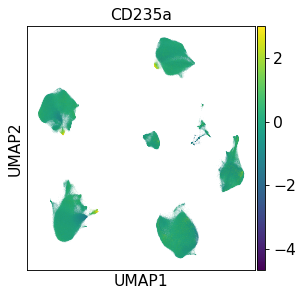

In [21]:
sc.pl.umap(adata, color=['CD235a'], vmax=3)

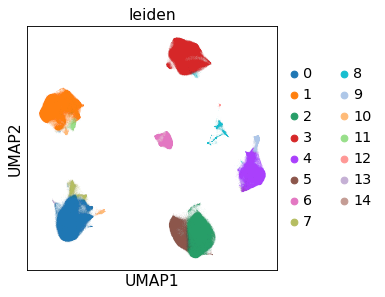

In [16]:
sc.pl.umap(adata, color=['leiden'])

In [17]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


In [18]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(8)

0       1         2       3       4         5       6       7       8  \
0     CD4     CD8      CD66    CD19    CD14     CD11b   CD161     CD4    Ki67   
1     CD3     CD3     CD11b     IgM   BDCA3     Erk12    CD16    CD45  HLA-DR   
2     CD7    CD27     Erk12    CD1c   CD11b        S6     CD7     CD3    CD38   
3    CD27     CD7     BDCA3  HLA-DR   STAT1      CD66    CD38     CD8   CD123   
4    CD45    CD45  Zap70Syk   4EBP1    CD56      CREB     CD8  CD235a    CD16   
5    CREB     CD4        S6    IkBa  HLA-DR     STAT5   CD11c   CD123   BDCA3   
6    IkBa    CREB      CD33    CD38    CD16  MAPKAPK2    CD27    CD27    CD1c   
7  Fox_P3  Fox_P3      CD14    CD56   CD11c       P38  Fox_P3   STAT1    CD19   

        9      10     11      12      13     14  
0   CD11c  CD235a   Ki67     IgM     CD3   CD61  
1    CD16     CD3    CD8    CD38   STAT6  STAT4  
2   BDCA3     CD4   CD38    Ki67  Fox_P3    IgM  
3  HLA-DR    CD45   CD45  HLA-DR   PLCg2   CD19  
4   STAT1  Fox_P3    CD3    CD19    IkBa   CD45  
5    CD56   STAT6   CD27    CD16   CD123   CD56  
6  CD45RA    IkBa  STAT1  CD45RA  CD235a  STAT6  
7   STAT3     CD8    CD4    CD56   STAT4   Ki67

... storing 'leiden14' as categorical
... storing 'leiden13' as categorical
... storing 'leiden10' as categorical
... storing 'leiden12' as categorical


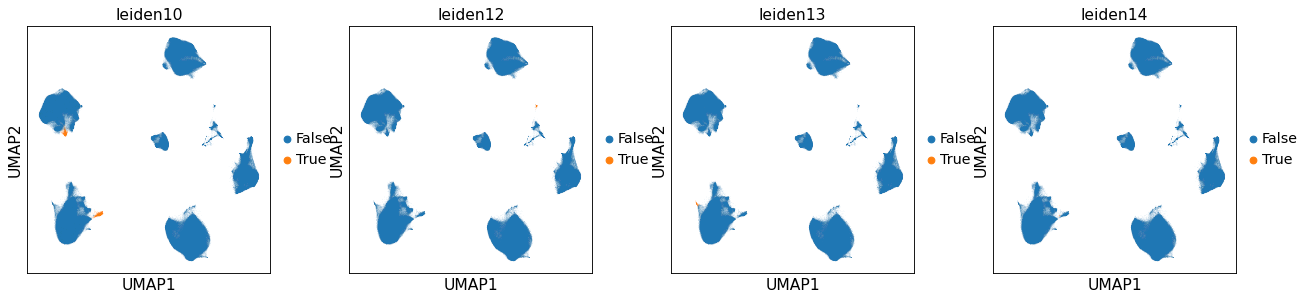

In [23]:
adata.obs['leiden10'] = (adata.obs['leiden']=='10').astype(str)
adata.obs['leiden14'] = (adata.obs['leiden']=='14').astype(str)
adata.obs['leiden13'] = (adata.obs['leiden']=='13').astype(str)
adata.obs['leiden12'] = (adata.obs['leiden']=='12').astype(str)

sc.pl.umap(adata, color=['leiden10', 'leiden12', 'leiden13', 'leiden14'])

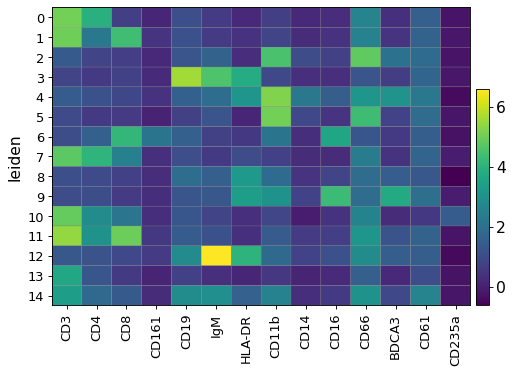

In [24]:
marker_genes = ['CD3', 'CD4', 'CD8', 'CD161', 'CD19', 'IgM', 'HLA-DR', 'CD11b', 'CD14', 'CD16', 'CD66', 'BDCA3', 'CD61', 'CD235a']
gs = sc.pl.matrixplot(adata,marker_genes, groupby='leiden', figsize=(7,5))

In [25]:
labmap = {'0':'Th 1', '1':'Tc 1', '2':'Neut 1', '3':'B 1', '4':'Mono/DC 1', '5':'Neut 2', '6':'NK 1', '7':'Th 2', 
          '8':'HLA-DR_high 1', '9':'Mono/DC 2', '10':'RBC 1', '11':'Tc 2', '12':'Plasmablast', '13':'Th 3', '14':'Doublet'}

In [26]:
adata.obs['leiden_lab'] = adata.obs['leiden'].replace(labmap)
adata.obs['leiden_lab_group'] = adata.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

In [27]:
adata.obs['leiden_lab_group'].value_counts()

Th             223002
Neut           215050
Tc             187970
B              157899
Mono/DC        102704
NK              34636
HLA-DR_high     13863
RBC              7030
Plasmablast      1361
Doublet            43
Name: leiden_lab_group, dtype: int64

... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


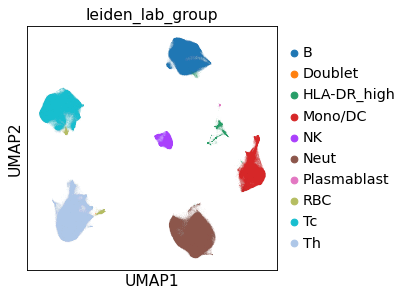

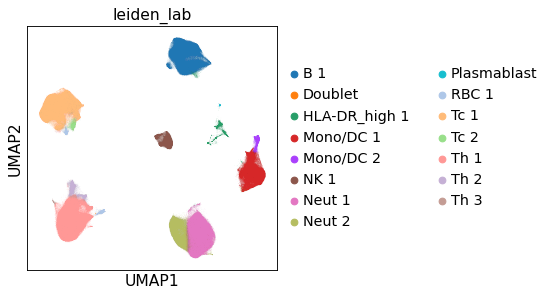

In [28]:
sc.pl.umap(adata, color=['leiden_lab_group'])
sc.pl.umap(adata, color=['leiden_lab'])

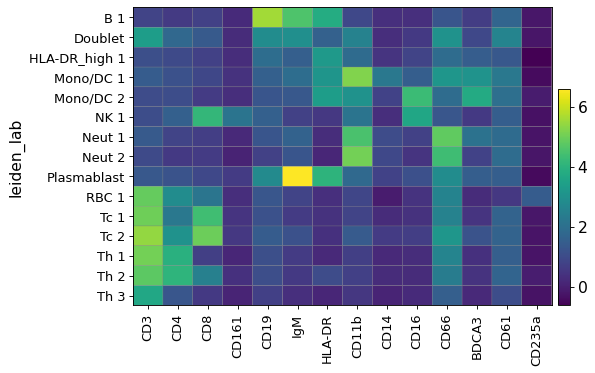

In [29]:
marker_genes = ['CD3', 'CD4', 'CD8', 'CD161', 'CD19', 'IgM', 'HLA-DR', 'CD11b', 'CD14', 'CD16', 'CD66', 'BDCA3', 'CD61', 'CD235a']
gs = sc.pl.matrixplot(adata,marker_genes, groupby='leiden_lab', figsize=(7,5))

In [30]:
#### These will be filled in in the upcoming subclustering steps
adata.obs['Subclustering'] = np.nan
adata.obs['SubclusteringGroup'] = np.nan
adata.obs['Doublet'] = False

In [33]:
sample_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.h5ad')
sample_file

'../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.h5ad'

In [32]:
save_adata(adata, sample_file, ext='.h5ad', gcs=gcs)


Only considering the two last: ['.Leiden', '.h5ad'].
Only considering the two last: ['.Leiden', '.h5ad'].


<a id="Subclustering"></a>
## Run subclustering on B-cells, myeloid cells, and T/NK cells

In [ ]:
base_nbcommand = '''jupyter nbconvert --ExecutePreprocessor.allow_errors=True --ExecutePreprocessor.timeout=-1 --ExecutePreprocessor.timeout=-1 \
--FilesWriter.build_directory=../../../../results --execute %s'''


In [ ]:
! {base_nbcommand % 'Subclustering/Subcluster.Cytof.B.ipynb'}
! {base_nbcommand % 'Subclustering/Subcluster.Cytof.Myeloid.ipynb'}
! {base_nbcommand % 'Subclustering/Subcluster.Cytof.TNK.ipynb'}

<a id="clustering4"></a>
## Final sub-clustering after filtering doublets found during subclustering

In [34]:
subcluster_out_fn = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloidTNK.h5ad')



In [35]:
adata = read_adata(subcluster_out_fn, ext='.h5ad', gcs=gcs)


Only considering the two last: ['.SubclusterBMyeloidTNK', '.h5ad'].
Only considering the two last: ['.SubclusterBMyeloidTNK', '.h5ad'].


In [36]:
pd.crosstab(adata.obs['leiden_lab_group'], adata.obs['Subclustering']).T

leiden_lab_group              B  Doublet  HLA-DR_high  Mono/DC     NK   Neut  \
Subclustering                                                                  
B_IgMhi_CD27lo_CD1chi 1   23437        0            0        0      0      0   
B_IgMhi_CD27lo_CD1chi 2   15776        0            0        0      0      0   
B_IgMhi_CD27lo_CD1chi 3   13214        0            0        0      0      0   
B_IgMhi_CD27lo_CD1chi 4   12748        0            0        0      0      0   
B_IgMhi_CD27lo_CD1chi 5    2845        0            0        0      0      0   
B_IgMhi_CD27lo_CD1chi 6    2217        0            0        0      0      0   
B_IgMhi_CD27lo_CD1clo 1   13617        0            0        0      0      0   
B_IgMhi_CD27lo_CD1clo 2   12526        0            0        0      0      0   
B_IgMhi_CD27lo_CD1clo 3    4059        0            0        0      0      0   
B_IgMlo_CD27hi_CD1chi 1   21401        0            0        0      0      0   
B_IgMlo_CD27hi_CD1chi 2   18837        0            0        0      0      0   
B_IgMlo_CD27hi_CD1clo 1   17183        0            0        0      0      0   
Basophil 1                    0        0         1743        0      0      0   
Doublet 1                     0        0          461        2      0      1   
Doublet 2                     0        0          270       17      0      7   
Doublet 3                     0        0          251        0      0      0   
Mono 1                        0        0           85    38837      0    362   
Mono 2                        0        0           25    30912      0     15   
Mono 3                        0        0            4    23413      0     12   
Mono 4                        0        0            7     8938      0    387   
NK 1                          0        0            0        0  29911      0   
Neut 1                        0        0            4        4      0  52898   
Neut 2                        0        0            0       66      0  35756   
Neut 3                        0        0            0       25      0  33355   
Neut 4                        0        0            0        9      0  26168   
Neut 5                        0        0            2       21      0  24651   
Neut 6                        0        0            0      253      0  23584   
Neut 7                        0        0            0        0      0  15826   
Neut 8                        0        0           32       51      0   1436   
Neut 9                        0        0            0        2      0    581   
Plasmablast 1                39        0            0        0      0      0   
Tc_CD7hi 1                    0        0            0        0      0      0   
Tc_CD7hi 2                    0        0            0        0      0      0   
Tc_CD7hi 3                    0        0            0        0      1      0   
Tc_CD7hi 4                    0        0            0        0      1      0   
Tc_CD7hi 5                    0        0            0        0      0      0   
Tc_CD7lo 1                    0        0            0        0      1      0   
Tc_CD7lo 2                    0        0            0        0      2      0   
Tc_CD161hi_CD7lo 1            0        0            0        0      1      0   
Th_CD7hi 1                    0        0            0        0      0      0   
Th_CD7hi 2                    0        0            0        0      0      0   
Th_CD7hi 3                    0        0            0        0      0      0   
Th_CD7hi 4                    0        0            0        0      0      0   
Th_CD7hi 5                    0        0            0        0      0      0   
Th_CD7hi 6                    0        0            0        0      0      0   
Th_CD7hi 7                    0        0            0        0      0      0   
Th_CD7hi 8                    0        0            0        0      0      0   
Th_CD7hi 9                    0        0            0        0      0      0   


In [37]:
adata.obs['SubclusteringGroup'].value_counts()

Neut                     214724
Th_CD7hi                 180726
Tc_CD7hi                 111590
Mono                     102997
B_IgMhi_CD27lo_CD1chi     70246
Tc_CD7lo                  43960
B_IgMlo_CD27hi_CD1chi     40238
nan                       35156
Th_CD7lo                  31357
B_IgMhi_CD27lo_CD1clo     30206
NK                        29924
Tc_CD161hi_CD7lo          19968
B_IgMlo_CD27hi_CD1clo     17183
Unassigned_APC             6124
cDC_CD1c+                  2308
Basophil                   1743
Plasmablast                1387
pDC                        1378
cDC_CD11c+                 1334
Doublet                    1009
Name: SubclusteringGroup, dtype: int64

In [38]:
adata.obs.loc[adata.obs['SubclusteringGroup'].isin(['nan', 'Doublet']), 'Subclustering'].value_counts()

nan                         35156
Doublet 1                     464
Doublet 2                     294
Doublet 3                     251
Neut 7                          0
Neut 6                          0
Neut 5                          0
Neut 4                          0
Neut 3                          0
Neut 2                          0
Neut 1                          0
NK 1                            0
Mono 4                          0
Mono 3                          0
Mono 2                          0
Mono 1                          0
pDC 1                           0
Basophil 1                      0
B_IgMlo_CD27hi_CD1clo 1         0
B_IgMlo_CD27hi_CD1chi 2         0
B_IgMlo_CD27hi_CD1chi 1         0
B_IgMhi_CD27lo_CD1clo 3         0
B_IgMhi_CD27lo_CD1clo 2         0
B_IgMhi_CD27lo_CD1clo 1         0
B_IgMhi_CD27lo_CD1chi 6         0
B_IgMhi_CD27lo_CD1chi 5         0
B_IgMhi_CD27lo_CD1chi 4         0
B_IgMhi_CD27lo_CD1chi 3         0
B_IgMhi_CD27lo_CD1chi 2         0
Neut 8        

In [39]:
adata = adata[~adata.obs['SubclusteringGroup'].isin(['nan', 'Doublet']), :]

In [40]:
adata.obs['SubclusteringGroup'].value_counts()

Neut                     214724
Th_CD7hi                 180726
Tc_CD7hi                 111590
Mono                     102997
B_IgMhi_CD27lo_CD1chi     70246
Tc_CD7lo                  43960
B_IgMlo_CD27hi_CD1chi     40238
Th_CD7lo                  31357
B_IgMhi_CD27lo_CD1clo     30206
NK                        29924
Tc_CD161hi_CD7lo          19968
B_IgMlo_CD27hi_CD1clo     17183
Unassigned_APC             6124
cDC_CD1c+                  2308
Basophil                   1743
Plasmablast                1387
pDC                        1378
cDC_CD11c+                 1334
Name: SubclusteringGroup, dtype: int64

In [41]:
adata.obs['Subclustering_reduced'] = adata.obs['SubclusteringGroup'].apply(lambda x: x.split('_')[0]).replace({'Unassigned':'Unassigned_APC'})

Trying to set attribute `.obs` of view, copying.


In [42]:
adata.obs['Subclustering_reduced'].value_counts()

Neut              214724
Th                212083
Tc                175518
B                 157873
Mono              102997
NK                 29924
Unassigned_APC      6124
cDC                 3642
Basophil            1743
Plasmablast         1387
pDC                 1378
Name: Subclustering_reduced, dtype: int64

In [43]:
pca_cytof(adata)

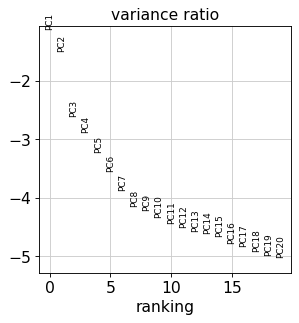

In [44]:
sc.pl.pca_variance_ratio(adata, log=True)

In [45]:
adata

AnnData object with n_obs × n_vars = 907393 × 42 
    obs: 'BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1', 'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI', 'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode', 'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1', 'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5', 'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width', 'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context', 'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample', 'sum_intensity', 'leiden14', 'leiden13', 'leiden10', 'leiden12', 'Subclustering', 'SubclusteringGroup', 'Doublet', 'Subclustering_reduced'
    var: 'gene_symbol', 'metal', 'full_id'
    uns: 'DPIc_colors', 'leiden', 'leiden10_colors', 'leiden12_colors', 'leiden13_colors', 'leiden14_colors', 'leiden_colors', 'leiden_lab_group_colors', 'neighbors', 

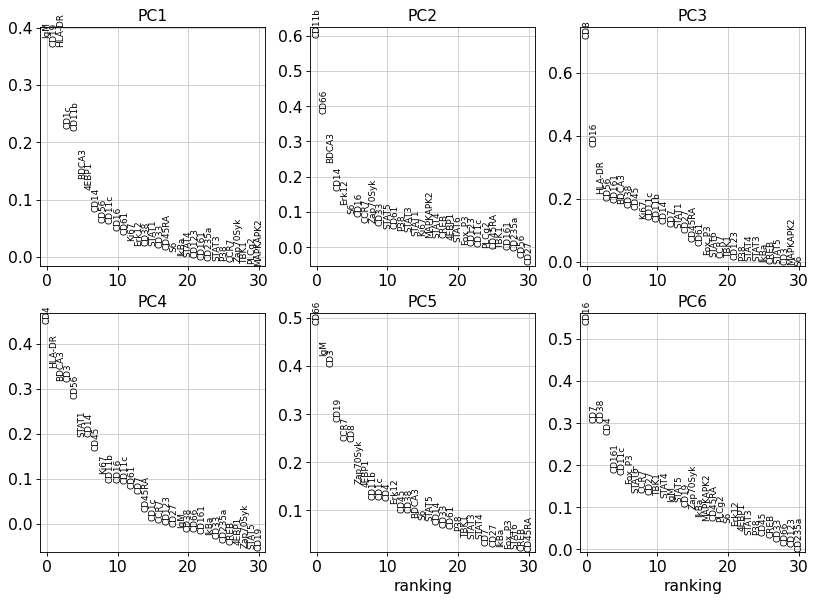

In [46]:
sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6])

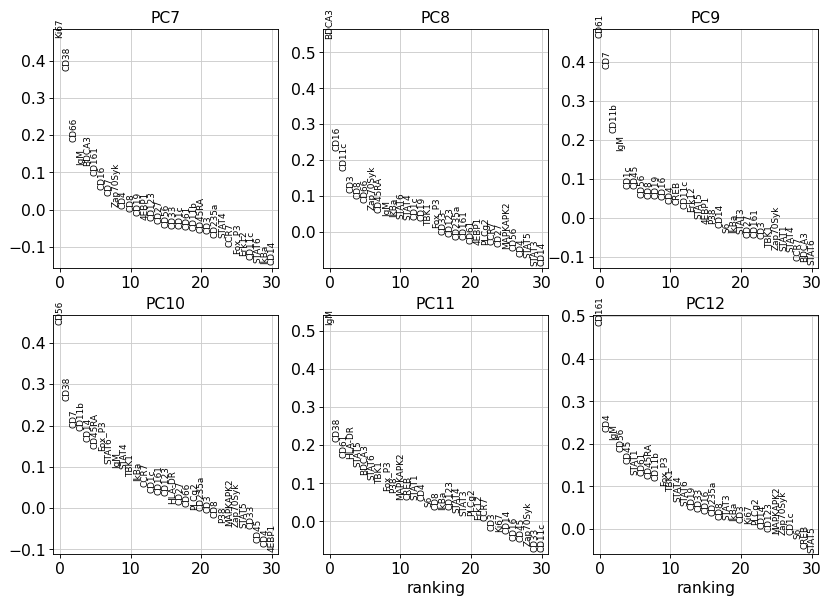

In [47]:
sc.pl.pca_loadings(adata, components=[7,8,9,10,11,12])

In [48]:
adata

AnnData object with n_obs × n_vars = 907393 × 42 
    obs: 'BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1', 'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI', 'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode', 'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1', 'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5', 'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width', 'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context', 'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample', 'sum_intensity', 'leiden14', 'leiden13', 'leiden10', 'leiden12', 'Subclustering', 'SubclusteringGroup', 'Doublet', 'Subclustering_reduced'
    var: 'gene_symbol', 'metal', 'full_id'
    uns: 'DPIc_colors', 'leiden', 'leiden10_colors', 'leiden12_colors', 'leiden13_colors', 'leiden14_colors', 'leiden_colors', 'leiden_lab_group_colors', 'neighbors', 

In [49]:
from joblib import parallel_backend
with parallel_backend('threading', n_jobs=15):
    sc.pp.neighbors(adata, n_neighbors=int(adata.shape[0]*.0001), n_pcs=18, random_state=14)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../..

In [98]:
with parallel_backend('threading', n_jobs=15):
    sc.tl.umap(adata, min_dist=0.1, spread=2.0, random_state=14)

findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.


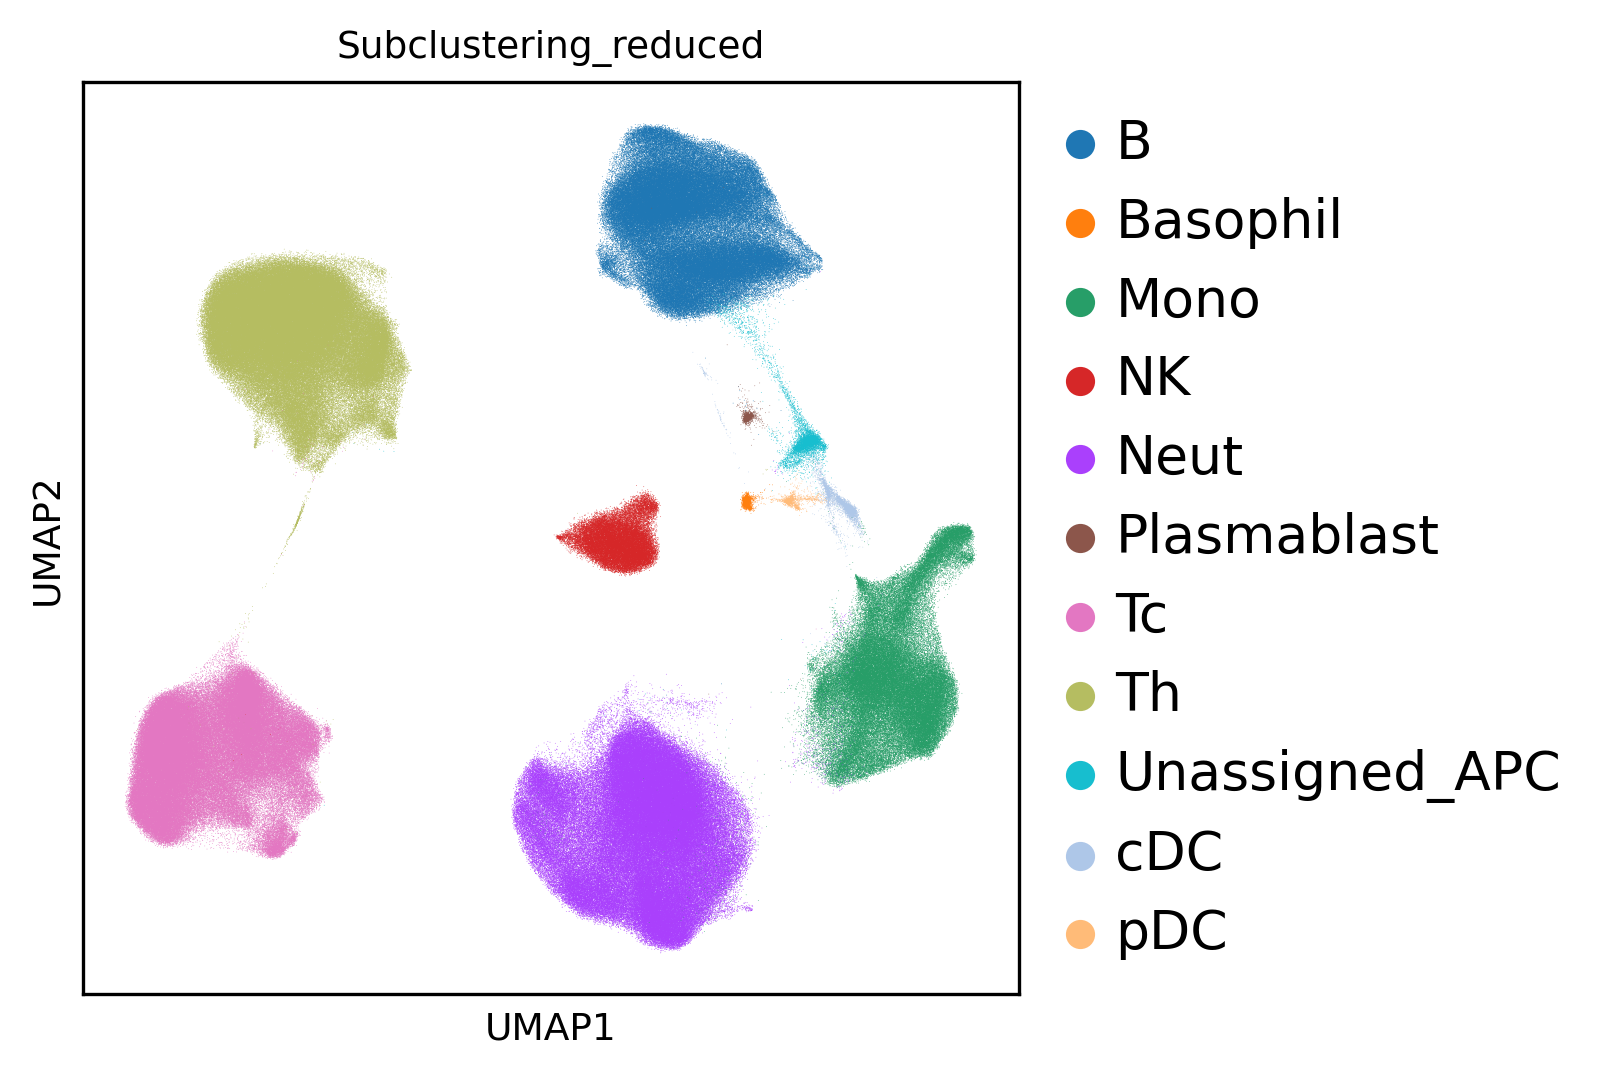

In [73]:
sc.pl.umap(adata, color='Subclustering_reduced')

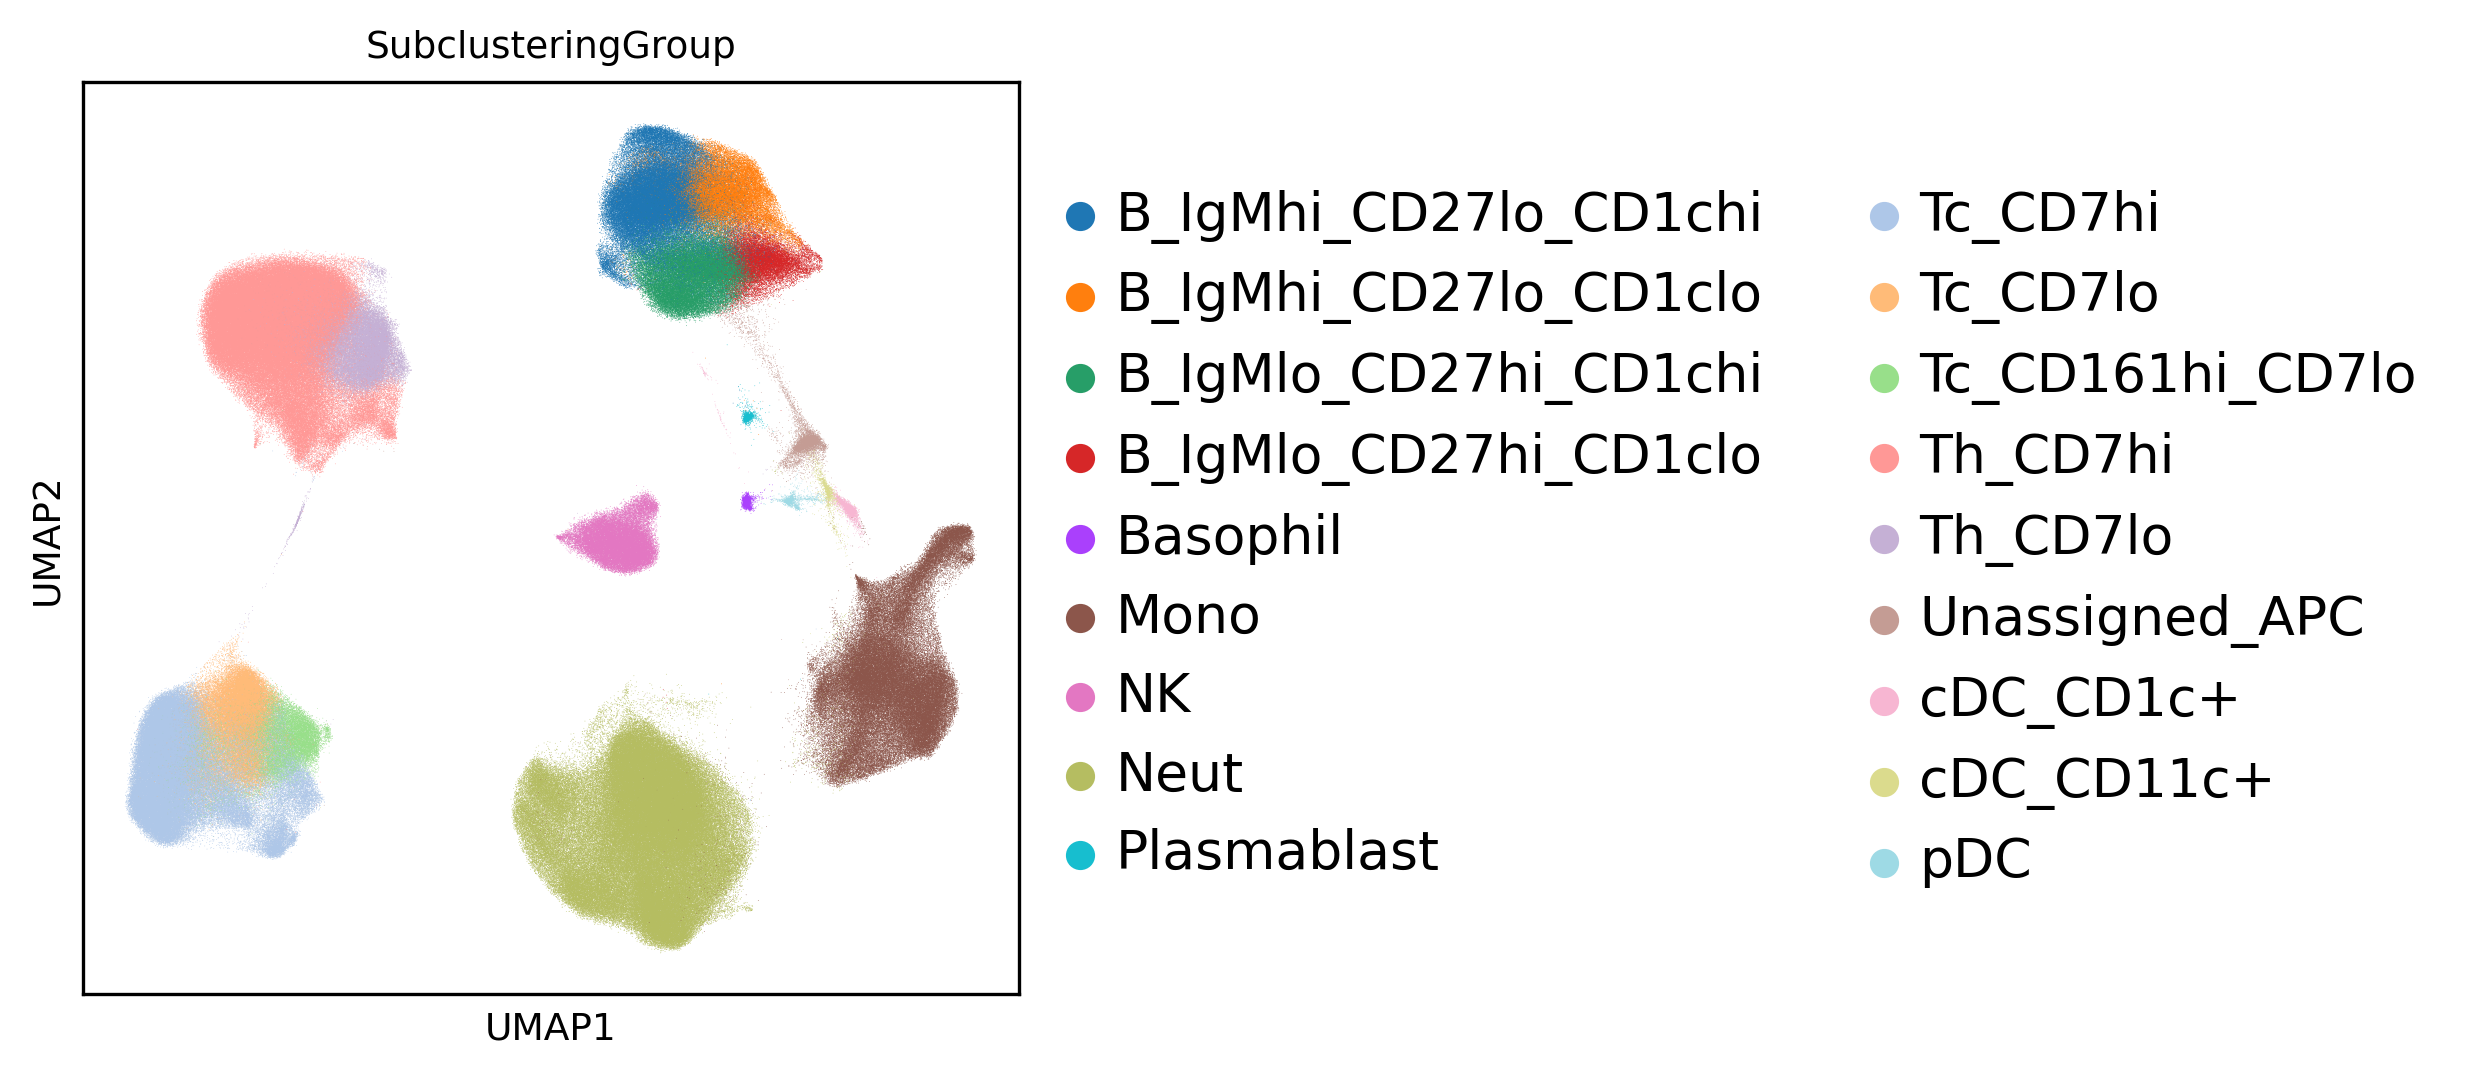

In [74]:
sc.pl.umap(adata, color='SubclusteringGroup')

In [3]:
processed_out_fn = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloidTNK.UMAP.Final.h5ad')
print(processed_out_fn)

../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloidTNK.UMAP.Final.h5ad


In [76]:
save_adata(adata, processed_out_fn, gcs=gcs)

Only considering the two last: ['.Final', '.h5ad'].
Only considering the two last: ['.Final', '.h5ad'].


In [4]:
adata = read_adata(processed_out_fn, gcs=gcs)

Only considering the two last: ['.Final', '.h5ad'].
Only considering the two last: ['.Final', '.h5ad'].


In [5]:
adata.var.shape

(42, 3)

In [11]:
adata.obs['sample'].unique().shape[0]

90

In [13]:
adata.obs[['DPI', 'sample']].drop_duplicates()['DPI'].value_counts()

-14    20
 3     12
 5      9
-30     6
-4      6
 4      6
 2      6
 1      6
 0      6
 6      5
-2      2
 8      2
 7      2
-7      1
-21     1
Name: DPI, dtype: int64

In [14]:
20+6+6+6+2+1+1

42

<a id="figures"></a>
## Make figures

<a id="markerplot"></a>
## Marker plot

In [104]:
adata_cytof_scale = sc.pp.scale(adata, copy=True)

In [13]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


fontpath = '../../../../data/misc/MyriadPro-Regular.ttf'
prop = font_manager.FontProperties(fname=fontpath)
rcParams['font.family'] = prop.get_name()

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

valdpi=100

In [ ]:
X = pd.DataFrame(adata_cytof_scale.X, index=adata_cytof_scale.obs.index, columns=adata_cytof_scale.var.index)

In [ ]:
average_expression = X.groupby(adata_cytof_scale.obs['Cell-type cluster']).mean()
marker_genes = ['IgM', 'CD19', 'CD3', 'CD8', 'CD4', 'CD161',  'CD16', 'HLA-DR','BDCA3','CD14', 'CD1c', 'CD123', 'CD66', 'CD38', 'Ki67']
celltype_order = ['B', 'Plasmablast', 'T CD8+', 'T CD4+', 'NK', 'Mono','cDC', 'pDC',  'Neut', 'Basophil']



width=3.9
heatmap_width=3.8
legend_width=1.1
left_space=.2

heatmap_height = 2.
bottom_space = .7
top_space = .1
height=heatmap_height+bottom_space+top_space

topval = 1-(top_space/height)
bottomval = bottom_space/height

fig = plt.figure(figsize=(width, height), dpi=150)
full_gs = gridspec.GridSpec(
        nrows=1,
        ncols=2,
        wspace=0,
        hspace=0,
        width_ratios=[
            heatmap_width,
            legend_width,
        ], left=left_space, right=.99, bottom=bottomval, top=topval)


legend_grid = full_gs[0, 1].subgridspec(1, 130, wspace=0, hspace=0,
                                           width_ratios=[.01]*130)

cbar_ax = fig.add_subplot(legend_grid[5:20], ylim=[0,1], xlim=[0,1], frameon=False)
size_legend_ax = fig.add_subplot(legend_grid[50:], ylim=[0,1], xlim=[0,1], frameon=False, yticks=[], xticks=[])

heatmap_ax = fig.add_subplot(full_gs[0])

vmin=-3.
vmax=3.
cmap = "RdBu_r"

cim= heatmap_ax.imshow(average_expression.loc[celltype_order, marker_genes], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
heatmap_ax.grid(False)
heatmap_ax.set_yticks(np.arange(len(celltype_order)))
heatmap_ax.set_yticklabels(celltype_order)

heatmap_ax.set_xticks(np.arange(len(marker_genes)))
heatmap_ax.set_xticklabels(marker_genes, rotation=90)        

plt.colorbar(cim, cax=cbar_ax, ticks=[-2, -1, 0, 1, 2])
#matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=normalize, ticks=[0,1,2,3,4,5,6,7])


vals = np.linspace(.2, 1, num=5)
leg_dot_size =  (vals * 9.4) ** 2
leg_dot_color = 'k'
text_offset = .2
leg_x_pos = .25

leg_x = np.array([leg_x_pos]*5)
leg_y = np.linspace(.5, .76, 5)

size_legend_ax.text(0.3, .5, 'CyTOF intensity', fontsize=sizelegendfontsize, ha='left', va='center', rotation=90)
    
figure_file = os.path.join(results_dir, "CellTypeMarker.Invivo.Cytof.Heatmap.pdf")
fig.savefig(figure_file, dpi=200)


## UMAPs

In [7]:
cols = ['DPI', 'DPIc', 'Multiplex_Barcode', 'Multiplex_Group',  'Period', 'animal',
        'clinical_score', 'context', 'intensity_sum', 'is_doublet',
       'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes',
       'samp', 'sample', 'sum_intensity', 'Subclustering', 'leiden14',
       'leiden13', 'SubclusteringGroup', 'Subclustering_reduced']

umapdata = adata.obs[cols]
umapdata['UMAP_1'] = adata.obsm['X_umap'][:,0]
umapdata['UMAP_2'] = adata.obsm['X_umap'][:,1]

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [8]:
umapdata['Subclustering_reduced'].value_counts()

Neut              214724
Th                212083
Tc                175518
B                 157873
Mono              102997
NK                 29924
Unassigned_APC      6124
cDC                 3642
Basophil            1743
Plasmablast         1387
pDC                 1378
Name: Subclustering_reduced, dtype: int64

In [9]:
umapdata['Subclustering_clean'] = umapdata['Subclustering_reduced'].replace({'Tc': 'T CD8+', 'Th': 'T CD4+', 'Unassigned_APC':'Unass. APC',
                                                                            'Mono':'Monocyte', 'Neut':'Neutrophil'})

colors = np.array([x for x in palettable.tableau.TrafficLight_9.hex_colors])
#sns.palplot(colors)
#sns.palplot(colors[[8,8,5, 7, 4, 1, 6,3,0], :])
dpimap = dict(zip(range(9), colors[[8,8,5, 7, 4, 1, 6,3,0]]))
dpimap[0] = palettable.tableau.TableauMedium_10.hex_colors[-1]

umapdata['dpi_color'] = umapdata['DPIc'].apply(lambda x: dpimap[int(x)])

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [10]:
pd.crosstab(umapdata['Subclustering_clean'], umapdata['Period'])

Period               Baseline  Early  Incubation    Late    Mid
Subclustering_clean                                            
B                       56875  16498       40735   20650  23115
Basophil                  312     96         476     794     65
Monocyte                26490  18695       17904   17975  21933
NK                       9856   1623        8286    6117   4042
Neutrophil              19894  10416        9526  106943  67945
Plasmablast               151     65         105     919    147
T CD4+                  63773  18423       44358   51873  33656
T CD8+                  56553  17017       33722   44798  23428
Unass. APC               1880    662        1309     977   1296
cDC                      1645    298        1134     354    211
pDC                       406    146         276     382    168

In [85]:
c = palettable.tableau.Tableau_20.hex_colors
cytof_celltype_cmap = {'B':c[0], 'Plasmablast':c[19], 'T CD8+':c[3], 'T CD4+':c[2], 'NK':c[6],'Monocyte':c[4],
          'cDC':c[5], 'pDC':c[16], 'Neutrophil':c[8], 'Platelet':c[9], 'Unass. APC':c[14], 'Basophil':c[15]}

umapdata['cluster_color'] = umapdata['Subclustering_clean'].apply(lambda x: cytof_celltype_cmap[x])

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [86]:
umapdata['Multiplex_Group_Num'] = umapdata['Multiplex_Group'].apply(lambda x: x.split(' ')[-1]).astype(int)
multiplex_group_cmap = dict(zip(umapdata['Multiplex_Group_Num'].unique(), palettable.tableau.Tableau_10.hex_colors[::-1]))
umapdata['Multiplex_Group_Color'] = umapdata['Multiplex_Group_Num'].apply(lambda x: multiplex_group_cmap[x])

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [87]:
umapdata['Ki67'] = adata.obs_vector('Ki67')
umapdata['CD38'] = adata.obs_vector('CD38')
umapdata['HLA-DR'] = adata.obs_vector('HLA-DR')
umapdata['CD14'] = adata.obs_vector('CD14')
umapdata['CD16'] = adata.obs_vector('CD16')

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [88]:
umap_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.SubclusterBMyeloidTNK.UMAP.Final.UMAPdata.tsv')
print(umap_file)
umapdata.to_csv(umap_file, sep='\t')

../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.SubclusterBMyeloidTNK.UMAP.Final.UMAPdata.tsv


In [89]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


fontpath = '../../../../data/misc/MyriadPro-Regular.ttf'
prop = font_manager.FontProperties(fname=fontpath)
rcParams['font.family'] = prop.get_name()

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

valdpi=100

<a id="umap_dpi"></a>
## UMAP DPI

In [90]:
box_height=1.7
box_width=1.7
title_height=.15
left_space = .02
right_space = .98
bottom_space = .02
top_space = .98

dotsize=.2

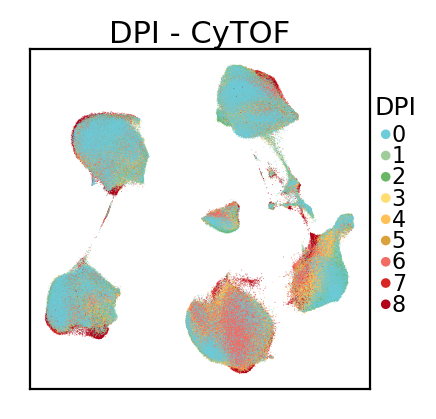

In [91]:
leg_width=.2
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))


ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='', xticks=[], yticks=[])

ax.scatter(umapdata['UMAP_1'], umapdata['UMAP_2'], c=umapdata['dpi_color'],
           s=.1, alpha=.7, edgecolor='None', rasterized=True)

'''
label_size = 8
ax.text(-15, -5, 'CD4+ T', fontsize=label_size)
ax.text(-10, 8, 'CD8+ T', fontsize=label_size)
ax.text(-3, 3, 'NK', fontsize=label_size)
ax.text(5, 10, 'B', fontsize=label_size)
ax.text(5, -2, 'Mono', fontsize=label_size)
#ax.text(1.6, 0, 'DC', fontsize=label_size)
ax.text(1,3, 'Plat.', fontsize=label_size)
ax.text(1, -9, 'Neutrophil', fontsize=label_size)
'''

legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.4
for (i,y) in enumerate(np.linspace(.75, .25, num=9)):
  legend_ax.scatter(marker_x, y, color=dpimap[i], s=12, edgecolor='None')
  legend_ax.text(marker_x+.15, y-.02, i, fontsize=8)
legend_ax.text(.13, .81, 'DPI', fontsize=9, ha='left')

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'DPI - CyTOF', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Cytof.Invivo.DPI.pdf")
fig.savefig(figure_file, dpi=300)

<a id="umap_celltype"></a>
## UMAP Cell type

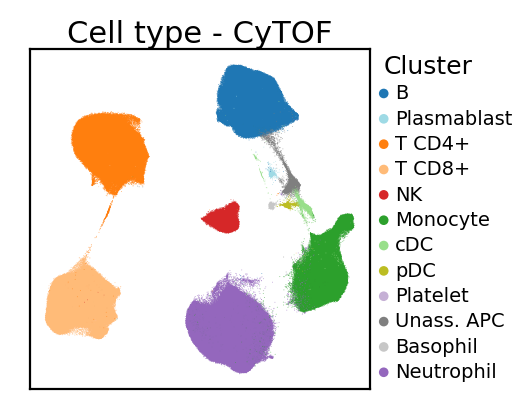

In [92]:
celltype_order = np.array(['B',  'Plasmablast',
                            'T CD4+', 'T CD8+', 'NK',
                           'Monocyte','cDC', 'pDC','Platelet',  'Unass. APC', 'Basophil',
                           'Neutrophil'])


leg_width=.7
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

ax.scatter(umapdata['UMAP_1'], umapdata['UMAP_2'],
           c=umapdata['cluster_color'],
           s=.1, alpha=.7, edgecolor='None', rasterized=True)

'''
label_size = 8
ax.text(-15, -5, 'CD4+ T', fontsize=label_size)
ax.text(-10, 8, 'CD8+ T', fontsize=label_size)
ax.text(-3, 3, 'NK', fontsize=label_size)
ax.text(5, 10, 'B', fontsize=label_size)
ax.text(5, -2, 'Mono', fontsize=label_size)
#ax.text(1.6, 0, 'DC', fontsize=label_size)
ax.text(1,3, 'Plat.', fontsize=label_size)
ax.text(1, -9, 'Neutrophil', fontsize=label_size)
'''

legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.1
N = len(celltype_order)
for (i,y) in enumerate(np.linspace(.87, .05, num=N)):
  ct = celltype_order[i]
  legend_ax.scatter(marker_x, y, color=cytof_celltype_cmap[ct], s=12, edgecolor='None')
  legend_ax.text(marker_x+.08, y-.015, ct, fontsize=7)
legend_ax.text(.1, .93, 'Cluster', fontsize=9)

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'Cell type - CyTOF', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Cytof.Invivo.Celltype.pdf")
fig.savefig(figure_file, dpi=300)

<a id="umap_batch"></a>
## UMAP batch

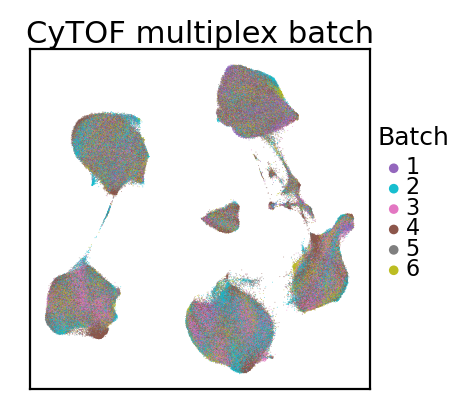

In [93]:
leg_width=.4
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

umapdata_random_order = umapdata.sample(frac=1)

ax.scatter(umapdata_random_order['UMAP_1'], umapdata_random_order['UMAP_2'],
           c=umapdata_random_order['Multiplex_Group_Color'],
           s=.1, alpha=.7, edgecolor='None', rasterized=True)


legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.3
for (i,y) in enumerate(np.linspace(.65, .35, num=len(multiplex_group_cmap))):
  legend_ax.scatter(marker_x, y, color=multiplex_group_cmap[i+1], s=12, edgecolor='None')
  legend_ax.text(marker_x+.15, y-.015, i+1, fontsize=8)
legend_ax.text(.1, .72, 'Batch', fontsize=9, ha='left')

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'CyTOF multiplex batch', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Cytof.Invivo.Batch.pdf")
fig.savefig(figure_file, dpi=300)

## Output file for comparison with manual gating

In [19]:
sampled_raw_file = os.path.join(adir, project_name + '.raw.h5ad')
print(sampled_raw_file)

../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.raw.h5ad


In [20]:
adata_raw = read_adata(sampled_raw_file, gcs=False)

Only considering the two last: ['.raw', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].


In [23]:
adata_raw.obs.head()

samp animal  DPI context         Time  \
NHP07.D003.LIVE_34361   NHP07.D003.LIVE  NHP07    3    LIVE   3510663.00   
NHP07.D003.LIVE_116133  NHP07.D003.LIVE  NHP07    3    LIVE  12414364.00   
NHP07.D003.LIVE_12620   NHP07.D003.LIVE  NHP07    3    LIVE   1213932.25   
NHP07.D003.LIVE_117138  NHP07.D003.LIVE  NHP07    3    LIVE  12505319.00   
NHP07.D003.LIVE_84000   NHP07.D003.LIVE  NHP07    3    LIVE   9441950.00   

                        Event_length  Pd102Di_BC1  Pd104Di_BC2  Pd105Di_BC3  \
NHP07.D003.LIVE_34361             15    32.258850     7.812205     3.158146   
NHP07.D003.LIVE_116133            17    59.575989    10.898479     7.089833   
NHP07.D003.LIVE_12620             17    24.166224     3.278962     0.000000   
NHP07.D003.LIVE_117138            13    39.343136    15.292664     4.290820   
NHP07.D003.LIVE_84000             13    42.878590     0.000000     7.180943   

                        Pd106Di_BC4  ...  DNA_Norm_Sum  DNA_Sum_Norm  \
NHP07.D003.LIVE_34361     33.883942  ...      5.692039      3.555815   
NHP07.D003.LIVE_116133    56.030071  ...      4.464424      3.023911   
NHP07.D003.LIVE_12620     36.822323  ...      4.396011      2.881895   
NHP07.D003.LIVE_117138    38.675659  ...      4.963192      3.372859   
NHP07.D003.LIVE_84000     43.475002  ...      3.833813      2.720783   

                           n_counts  n_genes      sample  Multiplex_Group  \
NHP07.D003.LIVE_34361   1191.418335       40  NHP07.D003   Barcode tube 2   
NHP07.D003.LIVE_116133  1766.152222       42  NHP07.D003   Barcode tube 2   
NHP07.D003.LIVE_12620    801.873840       39  NHP07.D003   Barcode tube 2   
NHP07.D003.LIVE_117138  1278.510864       40  NHP07.D003   Barcode tube 2   
NHP07.D003.LIVE_84000    595.420898       34  NHP07.D003   Barcode tube 2   

                        Multiplex_Barcode  clinical_score     num  \
NHP07.D003.LIVE_34361         102_106_110             0.0   34361   
NHP07.D003.LIVE_116133        102_106_110             0.0  116133   
NHP07.D003.LIVE_12620         102_106_110             0.0   12620   
NHP07.D003.LIVE_117138        102_106_110             0.0  117138   
NHP07.D003.LIVE_84000         102_106_110             0.0   84000   

                        Subclustering_reduced  
NHP07.D003.LIVE_34361                Filtered  
NHP07.D003.LIVE_116133               Filtered  
NHP07.D003.LIVE_12620                Filtered  
NHP07.D003.LIVE_117138               Filtered  
NHP07.D003.LIVE_84000                Filtered  

[5 rows x 41 columns]

In [31]:
umapdata.index = [x[:-2] for x in umapdata.index]

In [32]:
adata_raw.obs['Subclustering_reduced'] = 'Filtered'
adata_raw.obs.loc[umapdata.index, 'Subclustering_reduced'] = umapdata['Subclustering_reduced']

In [38]:
cellcount = adata_raw.obs[['samp', 'Subclustering_reduced', 'DPI']].groupby(['samp', 'Subclustering_reduced']).count().replace(np.nan, 0).reset_index().rename(columns={'DPI':'count'})

In [40]:
cellcount.to_csv('../../../../data/InVivo/Cytof/Broadclustering.Counts.Update20200513.tsv', sep='\t', index=False)